![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/academic/Commercial_Solutions_VS_Open_Source_Models_for_Medical_Context.ipynb)

# OpenPipe PII-Redact Performance Evaluation

In this notebook, we will evaluate **OpenPipe's PII-Redact** for **PII detection in text**. First, we’ll benchmark its performance using the **AI4Privacy dataset**, as highlighted in the [PII-Redact blog post](https://openpipe.ai/blog/pii-redact). In the second section, we’ll examine how well it performs on a **real-world clinical dataset** used in the study [*Can Zero-Shot Commercial APIs Deliver Regulatory-Grade Clinical Text DeIdentification?*](https://arxiv.org/abs/2503.20794).

## Setup

In [ ]:
!pip -q install pii-redact gliner

In [ ]:
from pii_redaction import tag_pii_in_documents, clean_dataset, PIIHandlingMode
# Process text documents
documents = ["My name is John Doe and my email is john.doe@example.com"]
# Tag PII (default mode)
tagged_documents = tag_pii_in_documents(documents, mode=PIIHandlingMode.TAG)

In [ ]:
tagged_documents

['My name is <PII:person_name>John Doe</PII:person_name> and my email is <PII:email_address>john.doe@example.com</PII:email_address>']

# Performance Test On AI4Privacy Dataset

The **[PII-Masking-300K](https://huggingface.co/datasets/ai4privacy/pii-masking-300k)** dataset, created by **AI4Privacy**, is a large-scale dataset designed for training and evaluating **Personally Identifiable Information (PII) masking models**. It contains **300,000 text samples** with **PII annotations and corresponding masked versions**, making it a valuable resource for **privacy-preserving NLP applications**.  

**Key Features:**  
- **Size**: 300,000 text samples  
- **Annotations**: Includes **PII-labeled** data with entities such as **names, addresses, emails, phone numbers, and other sensitive identifiers**.  
- **Masked Versions**: Each sample has a **corresponding deidentified version**, where PII has been replaced with placeholders or redacted.  
- **Diverse Sources**: The dataset is designed to cover a wide range of text formats, ensuring robustness for **real-world PII detection and masking tasks**.  
- **Use Cases**: Ideal for **training, benchmarking, and evaluating** PII detection models in **healthcare, finance, and legal sectors**.  

This dataset serves as a **benchmarking resource** for developing **privacy-focused AI models**, ensuring compliance with **data protection regulations like GDPR and HIPAA**.

In [ ]:
!pip -q install datasets

In [ ]:
from datasets import load_dataset
dataset = load_dataset("ai4privacy/pii-masking-300k")
dataset

In [ ]:
dataset["validation"][0].keys()

dict_keys(['source_text', 'target_text', 'privacy_mask', 'span_labels', 'mbert_text_tokens', 'mbert_bio_labels', 'id', 'language', 'set'])

In [ ]:
dataset["validation"][0]

{'source_text': "On the video sharing platform for educational content, a lively discussion unfolded among users from different locales within the UK.\n\nThe comment thread began with paaltwvkjuijwbj957 expressing admiration for the video's insightful content, followed by 2005zheng.monckton adding a clarification on a complex topic. 43CU chimed in with a question for clarification, an",
 'target_text': "On the video sharing platform for educational content, a lively discussion unfolded among users from different locales within the UK.\n\nThe comment thread began with [USERNAME] expressing admiration for the video's insightful content, followed by [USERNAME] adding a clarification on a complex topic. [USERNAME] chimed in with a question for clarification, an",
 'privacy_mask': [{'value': 'paaltwvkjuijwbj957',
   'start': 165,
   'end': 183,
   'label': 'USERNAME'},
  {'value': '2005zheng.monckton',
   'start': 254,
   'end': 272,
   'label': 'USERNAME'},
  {'value': '43CU', 'start': 316

We will get 100 random rows and work on that.

In [ ]:
pd.read_csv("ai4privacy_sample_text.csv")

,id,source_text,privacy_mask
0,47139B,together a comprehensive guide on the benefit...,"[{'value': '12/03/1982', 'start': 107, 'end': ..."
1,49394C,"hwatukee Foothills""\n },\n {...","[{'value': 'AZ', 'start': 97, 'end': 99, 'labe..."
2,51495A,**Inspection Record**\n\n**Date:** 31/08/2055 ...,"[{'value': '31/08/2055', 'start': 33, 'end': 4..."
3,44833A,"""Dear members of the legal community on Profes...","[{'value': 'ttattoni', 'start': 300, 'end': 30..."
4,45470A,"""Legal Chat Support - libel, slander, and defa...","[{'value': '5:40pm', 'start': 320, 'end': 326,..."
...,...,...,...
95,43451A,"{\n\t""FoodDiary"": {\n\t\t""Patient1"": {\n\t\t\t...","[{'value': 'Heir', 'start': 46, 'end': 50, 'la..."
96,45133B,P address **250.41.14.180**.\n\n3. **Omaima Am...,"[{'value': '250.41.14.180', 'start': 12, 'end'..."
97,48701A,```yaml\n- Parent Notice on Homework Policy No...,"[{'value': '23rd November 2020', 'start': 65, ..."
98,40802A,Subject: Welcome to Virtual Reality Classroom!...,"[{'value': 'September 2nd, 1945', 'start': 329..."


In [ ]:
# Convert to Pandas DataFrame
import pandas as pd

val_df = pd.DataFrame(dataset["validation"])
val_df = val_df[val_df.language=="English"]
text_df = val_df[val_df['privacy_mask'].apply(lambda x: len(x) > 0)]
text_df = text_df[['id', 'source_text', 'privacy_mask']]
text_df = text_df.sample(n=100, random_state=21).reset_index(drop=True)

text_df

,id,source_text,privacy_mask
0,47139B,together a comprehensive guide on the benefit...,"[{'value': '12/03/1982', 'start': 107, 'end': ..."
1,49394C,"hwatukee Foothills""\n },\n {...","[{'value': 'AZ', 'start': 97, 'end': 99, 'labe..."
2,51495A,**Inspection Record**\n\n**Date:** 31/08/2055 ...,"[{'value': '31/08/2055', 'start': 33, 'end': 4..."
3,44833A,"""Dear members of the legal community on Profes...","[{'value': 'ttattoni', 'start': 300, 'end': 30..."
4,45470A,"""Legal Chat Support - libel, slander, and defa...","[{'value': '5:40pm', 'start': 320, 'end': 326,..."
...,...,...,...
95,43451A,"{\n\t""FoodDiary"": {\n\t\t""Patient1"": {\n\t\t\t...","[{'value': 'Heir', 'start': 46, 'end': 50, 'la..."
96,45133B,P address **250.41.14.180**.\n\n3. **Omaima Am...,"[{'value': '250.41.14.180', 'start': 12, 'end'..."
97,48701A,```yaml\n- Parent Notice on Homework Policy No...,"[{'value': '23rd November 2020', 'start': 65, ..."
98,40802A,Subject: Welcome to Virtual Reality Classroom!...,"[{'value': 'September 2nd, 1945', 'start': 329..."


In [ ]:
text_df.to_csv("ai4privacy_sample_text.csv", index=False)

## OpenPipe's PII-Redact

In [ ]:
import pandas as pd

text_df = pd.read_csv("ai4privacy_sample_text.csv")
text_df

,id,source_text,privacy_mask
0,47139B,together a comprehensive guide on the benefit...,"[{'value': '12/03/1982', 'start': 107, 'end': ..."
1,49394C,"hwatukee Foothills""\n },\n {...","[{'value': 'AZ', 'start': 97, 'end': 99, 'labe..."
2,51495A,**Inspection Record**\n\n**Date:** 31/08/2055 ...,"[{'value': '31/08/2055', 'start': 33, 'end': 4..."
3,44833A,"""Dear members of the legal community on Profes...","[{'value': 'ttattoni', 'start': 300, 'end': 30..."
4,45470A,"""Legal Chat Support - libel, slander, and defa...","[{'value': '5:40pm', 'start': 320, 'end': 326,..."
...,...,...,...
95,43451A,"{\n\t""FoodDiary"": {\n\t\t""Patient1"": {\n\t\t\t...","[{'value': 'Heir', 'start': 46, 'end': 50, 'la..."
96,45133B,P address **250.41.14.180**.\n\n3. **Omaima Am...,"[{'value': '250.41.14.180', 'start': 12, 'end'..."
97,48701A,```yaml\n- Parent Notice on Homework Policy No...,"[{'value': '23rd November 2020', 'start': 65, ..."
98,40802A,Subject: Welcome to Virtual Reality Classroom!...,"[{'value': 'September 2nd, 1945', 'start': 329..."


In [ ]:
%%time

documents = text_df.source_text.to_list()
tagged_documents = tag_pii_in_documents(documents, mode=PIIHandlingMode.TAG)

text_df["predictions"] = tagged_documents
text_df

CPU times: user 18min 7s, sys: 11.6 s, total: 18min 18s
Wall time: 19min 2s


,id,source_text,privacy_mask,predictions
0,47139B,together a comprehensive guide on the benefit...,"[{'value': '12/03/1982', 'start': 107, 'end': ...",together a comprehensive guide on the benefit...
1,49394C,"hwatukee Foothills""\n },\n {...","[{'value': 'AZ', 'start': 97, 'end': 99, 'labe...","hwatukee Foothills""\n },\n {..."
2,51495A,**Inspection Record**\n\n**Date:** 31/08/2055 ...,"[{'value': '31/08/2055', 'start': 33, 'end': 4...",**Inspection Record**\n\n**Date:** <PII:date>3...
3,44833A,"""Dear members of the legal community on Profes...","[{'value': 'ttattoni', 'start': 300, 'end': 30...","""Dear members of the legal community on Profes..."
4,45470A,"""Legal Chat Support - libel, slander, and defa...","[{'value': '5:40pm', 'start': 320, 'end': 326,...","""Legal Chat Support - libel, slander, and defa..."
...,...,...,...,...
95,43451A,"{\n\t""FoodDiary"": {\n\t\t""Patient1"": {\n\t\t\t...","[{'value': 'Heir', 'start': 46, 'end': 50, 'la...","{\n\t""FoodDiary"": {\n\t\t""Patient1"": {\n\t\t\t..."
96,45133B,P address **250.41.14.180**.\n\n3. **Omaima Am...,"[{'value': '250.41.14.180', 'start': 12, 'end'...",P address **<PII:other_id>250.41.14.180</PII:o...
97,48701A,```yaml\n- Parent Notice on Homework Policy No...,"[{'value': '23rd November 2020', 'start': 65, ...",```yaml\n- Parent Notice on Homework Policy No...
98,40802A,Subject: Welcome to Virtual Reality Classroom!...,"[{'value': 'September 2nd, 1945', 'start': 329...",Subject: Welcome to Virtual Reality Classroom!...


In [ ]:
text_df.to_csv("ai4privacy_prediction.csv", index=False)

In [ ]:
import pandas as pd
import ast

text_df = pd.read_csv("ai4privacy_prediction.csv")
text_df = text_df.rename(columns={"id":"doc_id", "source_text":"text"})

text_df['privacy_mask'] = text_df['privacy_mask'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

text_df

,doc_id,text,privacy_mask,predictions
0,47139B,together a comprehensive guide on the benefit...,"[{'value': '12/03/1982', 'start': 107, 'end': ...",together a comprehensive guide on the benefit...
1,49394C,"hwatukee Foothills""\n },\n {...","[{'value': 'AZ', 'start': 97, 'end': 99, 'labe...","hwatukee Foothills""\n },\n {..."
2,51495A,**Inspection Record**\n\n**Date:** 31/08/2055 ...,"[{'value': '31/08/2055', 'start': 33, 'end': 4...",**Inspection Record**\n\n**Date:** <PII:date>3...
3,44833A,"""Dear members of the legal community on Profes...","[{'value': 'ttattoni', 'start': 300, 'end': 30...","""Dear members of the legal community on Profes..."
4,45470A,"""Legal Chat Support - libel, slander, and defa...","[{'value': '5:40pm', 'start': 320, 'end': 326,...","""Legal Chat Support - libel, slander, and defa..."
...,...,...,...,...
95,43451A,"{\n\t""FoodDiary"": {\n\t\t""Patient1"": {\n\t\t\t...","[{'value': 'Heir', 'start': 46, 'end': 50, 'la...","{\n\t""FoodDiary"": {\n\t\t""Patient1"": {\n\t\t\t..."
96,45133B,P address **250.41.14.180**.\n\n3. **Omaima Am...,"[{'value': '250.41.14.180', 'start': 12, 'end'...",P address **<PII:other_id>250.41.14.180</PII:o...
97,48701A,```yaml\n- Parent Notice on Homework Policy No...,"[{'value': '23rd November 2020', 'start': 65, ...",```yaml\n- Parent Notice on Homework Policy No...
98,40802A,Subject: Welcome to Virtual Reality Classroom!...,"[{'value': 'September 2nd, 1945', 'start': 329...",Subject: Welcome to Virtual Reality Classroom!...


**Prepare Ground Truth And Predictions For Comparison**

In [ ]:
# Explode the privacy_mask column to create separate rows for each dictionary
gt_text_df = text_df.drop("predictions", axis=1).explode("privacy_mask")

# Extract values from the privacy_mask dictionaries into separate columns
gt_text_df['begin'] = gt_text_df['privacy_mask'].apply(lambda x: x['start'] if isinstance(x, dict) else None)
gt_text_df['end'] = gt_text_df['privacy_mask'].apply(lambda x: x['end'] if isinstance(x, dict) else None)
gt_text_df['chunk'] = gt_text_df['privacy_mask'].apply(lambda x: x['value'] if isinstance(x, dict) else None)
gt_text_df['chunk_label'] = gt_text_df['privacy_mask'].apply(lambda x: x['label'] if isinstance(x, dict) else None)
gt_text_df

,doc_id,text,privacy_mask,begin,end,chunk,chunk_label
0,47139B,together a comprehensive guide on the benefit...,"{'value': '12/03/1982', 'start': 107, 'end': 1...",107,117,12/03/1982,BOD
0,47139B,together a comprehensive guide on the benefit...,"{'value': 'Marinês', 'start': 235, 'end': 242,...",235,242,Marinês,GIVENNAME1
0,47139B,together a comprehensive guide on the benefit...,"{'value': 'August 24th, 1986', 'start': 246, '...",246,263,"August 24th, 1986",BOD
0,47139B,together a comprehensive guide on the benefit...,"{'value': 'Dorinda', 'start': 271, 'end': 278,...",271,278,Dorinda,GIVENNAME1
1,49394C,"hwatukee Foothills""\n },\n {...","{'value': 'AZ', 'start': 97, 'end': 99, 'label...",97,99,AZ,STATE
...,...,...,...,...,...,...,...
97,48701A,```yaml\n- Parent Notice on Homework Policy No...,"{'value': '8:09 AM', 'start': 92, 'end': 99, '...",92,99,8:09 AM,TIME
98,40802A,Subject: Welcome to Virtual Reality Classroom!...,"{'value': 'September 2nd, 1945', 'start': 329,...",329,348,"September 2nd, 1945",BOD
98,40802A,Subject: Welcome to Virtual Reality Classroom!...,"{'value': '2069-10-02T00:00:00', 'start': 371,...",371,390,2069-10-02T00:00:00,DATE
98,40802A,Subject: Welcome to Virtual Reality Classroom!...,"{'value': '375', 'start': 403, 'end': 406, 'la...",403,406,375,BUILDING


In [ ]:
gt_text_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 679 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   doc_id        679 non-null    object
 1   text          679 non-null    object
 2   privacy_mask  679 non-null    object
 3   begin         679 non-null    int64 
 4   end           679 non-null    int64 
 5   chunk         679 non-null    object
 6   chunk_label   679 non-null    object
dtypes: int64(2), object(5)
memory usage: 42.4+ KB


In [ ]:
gt_text_df.to_csv("ai4privacy_gt_text_df.csv", index=False)

In [ ]:
prediction_df = text_df.drop("privacy_mask", axis=1)
prediction_df

,doc_id,text,predictions
0,47139B,together a comprehensive guide on the benefit...,together a comprehensive guide on the benefit...
1,49394C,"hwatukee Foothills""\n },\n {...","hwatukee Foothills""\n },\n {..."
2,51495A,**Inspection Record**\n\n**Date:** 31/08/2055 ...,**Inspection Record**\n\n**Date:** <PII:date>3...
3,44833A,"""Dear members of the legal community on Profes...","""Dear members of the legal community on Profes..."
4,45470A,"""Legal Chat Support - libel, slander, and defa...","""Legal Chat Support - libel, slander, and defa..."
...,...,...,...
95,43451A,"{\n\t""FoodDiary"": {\n\t\t""Patient1"": {\n\t\t\t...","{\n\t""FoodDiary"": {\n\t\t""Patient1"": {\n\t\t\t..."
96,45133B,P address **250.41.14.180**.\n\n3. **Omaima Am...,P address **<PII:other_id>250.41.14.180</PII:o...
97,48701A,```yaml\n- Parent Notice on Homework Policy No...,```yaml\n- Parent Notice on Homework Policy No...
98,40802A,Subject: Welcome to Virtual Reality Classroom!...,Subject: Welcome to Virtual Reality Classroom!...


In [ ]:
import re
import json

def get_entities_from_predictions(text):
    # ✅ Updated regex to handle **multiline entities** and **all labels**
    pattern = r'<PII:([\w_]+)>([\s\S]*?)</PII:\1>'

    # ✅ Extract all matches: (label, entity, start, end)
    matches = [(m.group(1), m.group(2).strip(), m.start(), m.end()) for m in re.finditer(pattern, text)]

    # ✅ Remove all PII tags to get clean text
    clean_text = re.sub(r'</?PII:[\w_]+>', '', text)

    # ✅ Adjust positions after tag removal
    adjusted_positions = []

    for label, entity, start, end in matches:
        # ✅ Compute new start position after tag removal
        start_index = len(re.sub(r'</?PII:[\w_]+>', '', text[:start]))  # Clean text length before entity
        end_index = start_index + len(entity)  # ✅ New end position
        adjusted_positions.append({"entity": entity, "label": label, "start": start_index, "end": end_index})

    # ✅ Convert to JSON
    json_output = json.dumps(adjusted_positions, indent=4)
    json_output = json.loads(json_output)  # Convert back to list

    # ✅ Print result
    return json_output

In [ ]:
# Apply get_entities to the predictions column
prediction_df['extracted_entities'] = prediction_df['predictions'].apply(get_entities_from_predictions)
prediction_df = prediction_df.explode("extracted_entities").reset_index(drop=True)

no_pred_files = prediction_df[prediction_df.extracted_entities.isna()].doc_id.to_list()
prediction_df = prediction_df[~prediction_df.doc_id.isin(no_pred_files)].reset_index(drop=True)
print("No Prediction Documents:", no_pred_files)
prediction_df

No Prediction Documents: ['43939C']


,doc_id,text,predictions,extracted_entities
0,47139B,together a comprehensive guide on the benefit...,together a comprehensive guide on the benefit...,"{'entity': '12/03/1982', 'label': 'date_of_bir..."
1,47139B,together a comprehensive guide on the benefit...,together a comprehensive guide on the benefit...,"{'entity': 'Marinês', 'label': 'person_name', ..."
2,47139B,together a comprehensive guide on the benefit...,together a comprehensive guide on the benefit...,"{'entity': 'August 24th, 1986', 'label': 'date..."
3,47139B,together a comprehensive guide on the benefit...,together a comprehensive guide on the benefit...,"{'entity': 'Dorinda', 'label': 'person_name', ..."
4,49394C,"hwatukee Foothills""\n },\n {...","hwatukee Foothills""\n },\n {...","{'entity': 'AZ', 'label': 'street_address', 's..."
...,...,...,...,...
669,40802A,Subject: Welcome to Virtual Reality Classroom!...,Subject: Welcome to Virtual Reality Classroom!...,"{'entity': 'Great Britain University', 'label'..."
670,40802A,Subject: Welcome to Virtual Reality Classroom!...,Subject: Welcome to Virtual Reality Classroom!...,"{'entity': 'September 2nd, 1945', 'label': 'da..."
671,40802A,Subject: Welcome to Virtual Reality Classroom!...,Subject: Welcome to Virtual Reality Classroom!...,"{'entity': '2069-10-02T00:00:00', 'label': 'da..."
672,40802A,Subject: Welcome to Virtual Reality Classroom!...,Subject: Welcome to Virtual Reality Classroom!...,"{'entity': '375', 'label': 'street_address', '..."


In [ ]:
import pandas as pd
def add_entity_columns(df, key_chunk="entity"):
  return pd.DataFrame({
      'doc_id': df['doc_id'],
      'text': df['text'],
      'begin': [entity_dict.get('start') if isinstance(entity_dict, dict) else None for entity_dict in df['extracted_entities']],
      'end': [entity_dict.get('end') if isinstance(entity_dict, dict) else None for entity_dict in df['extracted_entities']],
      'chunk': [entity_dict.get(key_chunk) if isinstance(entity_dict, dict) else None for entity_dict in df['extracted_entities']],
      'chunk_label': [entity_dict.get('label') if isinstance(entity_dict, dict) else None for entity_dict in df['extracted_entities']],
  })

In [ ]:
prediction_df = add_entity_columns(prediction_df)
prediction_df

,doc_id,text,predictions,begin,end,chunk,chunk_label
0,47139B,together a comprehensive guide on the benefit...,together a comprehensive guide on the benefit...,107,117,12/03/1982,date_of_birth
1,47139B,together a comprehensive guide on the benefit...,together a comprehensive guide on the benefit...,235,242,Marinês,person_name
2,47139B,together a comprehensive guide on the benefit...,together a comprehensive guide on the benefit...,246,263,"August 24th, 1986",date_of_birth
3,47139B,together a comprehensive guide on the benefit...,together a comprehensive guide on the benefit...,271,278,Dorinda,person_name
4,49394C,"hwatukee Foothills""\n },\n {...","hwatukee Foothills""\n },\n {...",97,99,AZ,street_address
...,...,...,...,...,...,...,...
669,40802A,Subject: Welcome to Virtual Reality Classroom!...,Subject: Welcome to Virtual Reality Classroom!...,149,173,Great Britain University,organization_name
670,40802A,Subject: Welcome to Virtual Reality Classroom!...,Subject: Welcome to Virtual Reality Classroom!...,329,348,"September 2nd, 1945",date_of_birth
671,40802A,Subject: Welcome to Virtual Reality Classroom!...,Subject: Welcome to Virtual Reality Classroom!...,371,390,2069-10-02T00:00:00,date
672,40802A,Subject: Welcome to Virtual Reality Classroom!...,Subject: Welcome to Virtual Reality Classroom!...,403,406,375,street_address


In [ ]:
prediction_df.to_csv("ai4privacy_chunk_prediction_df.csv", index=False)

## GLiNER PII

In [ ]:
from gliner import GLiNER

model = GLiNER.from_pretrained("urchade/gliner_multi_pii-v1")

In [ ]:
import pandas as pd

gt_text_df = pd.read_csv("ai4privacy_gt_text_df.csv")
text_df = pd.read_csv("ai4privacy_prediction.csv")
text_df = text_df.rename(columns={"source_text":"text"})[["doc_id", "text"]]
prediction_df = pd.read_csv("ai4privacy_chunk_prediction_df.csv")
text_df

,doc_id,text
0,47139B,together a comprehensive guide on the benefit...
1,49394C,"hwatukee Foothills""\n },\n {..."
2,51495A,**Inspection Record**\n\n**Date:** 31/08/2055 ...
3,44833A,"""Dear members of the legal community on Profes..."
4,45470A,"""Legal Chat Support - libel, slander, and defa..."
...,...,...
95,43451A,"{\n\t""FoodDiary"": {\n\t\t""Patient1"": {\n\t\t\t..."
96,45133B,P address **250.41.14.180**.\n\n3. **Omaima Am...
97,48701A,```yaml\n- Parent Notice on Homework Policy No...
98,40802A,Subject: Welcome to Virtual Reality Classroom!...


In [ ]:
prediction_df

,doc_id,text,predictions,begin,end,chunk,chunk_label
0,47139B,together a comprehensive guide on the benefit...,together a comprehensive guide on the benefit...,107,117,12/03/1982,date_of_birth
1,47139B,together a comprehensive guide on the benefit...,together a comprehensive guide on the benefit...,235,242,Marinês,person_name
2,47139B,together a comprehensive guide on the benefit...,together a comprehensive guide on the benefit...,246,263,"August 24th, 1986",date_of_birth
3,47139B,together a comprehensive guide on the benefit...,together a comprehensive guide on the benefit...,271,278,Dorinda,person_name
4,49394C,"hwatukee Foothills""\n },\n {...","hwatukee Foothills""\n },\n {...",97,99,AZ,street_address
...,...,...,...,...,...,...,...
669,40802A,Subject: Welcome to Virtual Reality Classroom!...,Subject: Welcome to Virtual Reality Classroom!...,149,173,Great Britain University,organization_name
670,40802A,Subject: Welcome to Virtual Reality Classroom!...,Subject: Welcome to Virtual Reality Classroom!...,329,348,"September 2nd, 1945",date_of_birth
671,40802A,Subject: Welcome to Virtual Reality Classroom!...,Subject: Welcome to Virtual Reality Classroom!...,371,390,2069-10-02T00:00:00,date
672,40802A,Subject: Welcome to Virtual Reality Classroom!...,Subject: Welcome to Virtual Reality Classroom!...,403,406,375,street_address


In [ ]:
prediction_df.chunk_label.unique()

array(['date_of_birth', 'person_name', 'street_address', 'date',
       'personal_id', 'phone_number', 'other_id', 'email_address',
       'gender', 'nationality', 'organization_name', 'password'],
      dtype=object)

In [ ]:
from tqdm import tqdm

labels = ['date_of_birth', 'person_name', 'street_address', 'date', 'personal_id', 'phone_number', 'other_id', 'email_address', 'gender', 'nationality', 'password']
predictions = []

for ind,row in tqdm(text_df.iterrows()):
    entities = model.predict_entities(row.text, labels)
    predictions.append(entities)

len(predictions)

0it [00:00, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
100it [01:32,  1.09it/s]


100

In [ ]:
gliner_pred_df = text_df.copy()
gliner_pred_df["extracted_entities"] = predictions
gliner_pred_df

,doc_id,text,extracted_entities
0,47139B,together a comprehensive guide on the benefit...,"[{'start': 270, 'end': 279, 'text': '[Dorinda]..."
1,49394C,"hwatukee Foothills""\n },\n {...","[{'start': 240, 'end': 257, 'text': 'Secondary..."
2,51495A,**Inspection Record**\n\n**Date:** 31/08/2055 ...,"[{'start': 33, 'end': 43, 'text': '31/08/2055'..."
3,44833A,"""Dear members of the legal community on Profes...","[{'start': 300, 'end': 308, 'text': 'ttattoni'..."
4,45470A,"""Legal Chat Support - libel, slander, and defa...","[{'start': 339, 'end': 342, 'text': 'ENG', 'la..."
...,...,...,...
95,43451A,"{\n\t""FoodDiary"": {\n\t\t""Patient1"": {\n\t\t\t...","[{'start': 46, 'end': 50, 'text': 'Heir', 'lab..."
96,45133B,P address **250.41.14.180**.\n\n3. **Omaima Am...,[]
97,48701A,```yaml\n- Parent Notice on Homework Policy No...,"[{'start': 65, 'end': 83, 'text': '23rd Novemb..."
98,40802A,Subject: Welcome to Virtual Reality Classroom!...,"[{'start': 53, 'end': 69, 'text': '[RECIPIENT_..."


In [ ]:
gliner_pred_df = gliner_pred_df.explode("extracted_entities").reset_index(drop=True)
gliner_pred_df

,doc_id,text,extracted_entities
0,47139B,together a comprehensive guide on the benefit...,"{'start': 270, 'end': 279, 'text': '[Dorinda]'..."
1,49394C,"hwatukee Foothills""\n },\n {...","{'start': 240, 'end': 257, 'text': 'Secondary ..."
2,49394C,"hwatukee Foothills""\n },\n {...","{'start': 282, 'end': 292, 'text': 'Office 373..."
3,51495A,**Inspection Record**\n\n**Date:** 31/08/2055 ...,"{'start': 33, 'end': 43, 'text': '31/08/2055',..."
4,51495A,**Inspection Record**\n\n**Date:** 31/08/2055 ...,"{'start': 121, 'end': 135, 'text': 'Onuma Koyu..."
...,...,...,...
306,48701A,```yaml\n- Parent Notice on Homework Policy No...,"{'start': 65, 'end': 83, 'text': '23rd Novembe..."
307,40802A,Subject: Welcome to Virtual Reality Classroom!...,"{'start': 53, 'end': 69, 'text': '[RECIPIENT_N..."
308,40802A,Subject: Welcome to Virtual Reality Classroom!...,"{'start': 329, 'end': 348, 'text': 'September ..."
309,40802A,Subject: Welcome to Virtual Reality Classroom!...,"{'start': 371, 'end': 390, 'text': '2069-10-02..."


In [ ]:
gliner_pred_df.extracted_entities.iloc[0]

{'start': 270,
 'end': 279,
 'text': '[Dorinda]',
 'label': 'person_name',
 'score': 0.5113414525985718}

In [ ]:
gliner_pred_df = gliner_pred_df.dropna().reset_index(drop=True)
gliner_pred_df = add_entity_columns(gliner_pred_df, key_chunk="text")
gliner_pred_df

,doc_id,text,begin,end,chunk,chunk_label
0,47139B,together a comprehensive guide on the benefit...,270,279,[Dorinda],person_name
1,49394C,"hwatukee Foothills""\n },\n {...",240,257,Secondary Address,street_address
2,49394C,"hwatukee Foothills""\n },\n {...",282,292,Office 373,street_address
3,51495A,**Inspection Record**\n\n**Date:** 31/08/2055 ...,33,43,31/08/2055,date
4,51495A,**Inspection Record**\n\n**Date:** 31/08/2055 ...,121,135,Onuma Koyutürk,person_name
...,...,...,...,...,...,...
291,48701A,```yaml\n- Parent Notice on Homework Policy No...,65,83,23rd November 2020,date
292,40802A,Subject: Welcome to Virtual Reality Classroom!...,53,69,[RECIPIENT_NAME],person_name
293,40802A,Subject: Welcome to Virtual Reality Classroom!...,329,348,"September 2nd, 1945",date_of_birth
294,40802A,Subject: Welcome to Virtual Reality Classroom!...,371,390,2069-10-02T00:00:00,date


In [ ]:
issue_ind = [j for j,i in gliner_pred_df.iterrows() if i.text[i.begin:i.end]!=i.chunk]
len(issue_ind)

0

In [ ]:
gliner_pred_df.to_csv("ai4privacy_gliner_prediction.csv", index=False)

## Chunk-Level Evaluation On AI4Privacy Dataset

The **`eval_chunk_base`** function is designed to compare two DataFrames (df1 and df2) that contain information about identified chunks of text. It aims to determine how well the chunks identified in df2 match the chunks in df1 (which is likely the ground truth).

**In the chunk-level evaluation, labels will be disregarded as the primary focus is on assessing PII entity detection performance. In deidentification tasks, accurately identifying PII entities is more critical than the specific labels assigned to them.**

**1. Comparing Chunks:**

The inner loop for n, m in tmp_df.iterrows(): iterates through each row (m) of the filtered df2 (i.e., chunks in the same document).

- **Full Match:** The first if condition checks if the chunk, begin, and end values in df1 and df2 are identical. If they are, it means there's a full match, and the function records "`full_match`" and the predicted label (`m.chunk_label`) from df2.

- **Partial Match**: The elif condition checks for various scenarios of partial overlap between the chunks based on their begin and end values. If any of these conditions are true, it means there's a partial match, and the function records "`partial_match`" and the predicted label.

- **Not Matched:** If none of the above conditions are true, it means the chunk in df1 was not found in df2, so the function records "`not_matched`" and "`no_prediction`".

**2. Appending Results:**

After comparing the chunk in df1 with all chunks in the filtered df2, the match_result and predictions lists are updated with the results.

**3. Returning Results:**

Finally, the function returns the `match_result` and `predictions` lists.


In [ ]:
def eval_chunk_base(df1, df2):
    match_result = []
    predictions = []

    for j, i in df1.iterrows():
        tmp_df = df2[df2.text == i.text]

        # Set defaults
        match_status = "not_matched"
        pred = "no_prediction"

        for n, m in tmp_df.iterrows():
            if (i.chunk == m.chunk) and (i.begin == m.begin) and (i.end == m.end):
                match_status = "full_match"
                pred = m.chunk_label
                break

            elif ((i.begin == m.begin) and (i.end != m.end)) or \
                 ((i.begin != m.begin) and (i.end == m.end)) or \
                 ((i.begin < m.begin) and (i.end > m.end)) or \
                 ((i.begin > m.begin) and (i.end < m.end)) or \
                 ((i.begin < m.begin) and (i.end < m.end) and (i.end > m.begin)) or \
                 ((i.begin > m.begin) and (i.begin < m.end) and (i.end > m.end)):

                match_status = "partial_match"
                pred = m.chunk_label
                break

        match_result.append(match_status)
        predictions.append(pred)

    return match_result, predictions


In [ ]:
prediction_df = pd.read_csv("ai4privacy_chunk_prediction_df.csv")

In [ ]:
prediction_df.head()

,doc_id,text,predictions,begin,end,chunk,chunk_label
0,47139B,together a comprehensive guide on the benefit...,together a comprehensive guide on the benefit...,107,117,12/03/1982,date_of_birth
1,47139B,together a comprehensive guide on the benefit...,together a comprehensive guide on the benefit...,235,242,Marinês,person_name
2,47139B,together a comprehensive guide on the benefit...,together a comprehensive guide on the benefit...,246,263,"August 24th, 1986",date_of_birth
3,47139B,together a comprehensive guide on the benefit...,together a comprehensive guide on the benefit...,271,278,Dorinda,person_name
4,49394C,"hwatukee Foothills""\n },\n {...","hwatukee Foothills""\n },\n {...",97,99,AZ,street_address


In [ ]:
gt_text_df["openpipe_is_matched"], gt_text_df["openpipe_prediction"]  = eval_chunk_base(gt_text_df, prediction_df)
gt_text_df["gliner_is_matched"], gt_text_df["gliner_prediction"]  = eval_chunk_base(gt_text_df, gliner_pred_df)

gt_text_df

,doc_id,text,privacy_mask,begin,end,chunk,chunk_label,openpipe_is_matched,openpipe_prediction,gliner_is_matched,gliner_prediction
0,47139B,together a comprehensive guide on the benefit...,"{'value': '12/03/1982', 'start': 107, 'end': 1...",107,117,12/03/1982,BOD,full_match,date_of_birth,not_matched,no_prediction
1,47139B,together a comprehensive guide on the benefit...,"{'value': 'Marinês', 'start': 235, 'end': 242,...",235,242,Marinês,GIVENNAME1,full_match,person_name,not_matched,no_prediction
2,47139B,together a comprehensive guide on the benefit...,"{'value': 'August 24th, 1986', 'start': 246, '...",246,263,"August 24th, 1986",BOD,full_match,date_of_birth,not_matched,no_prediction
3,47139B,together a comprehensive guide on the benefit...,"{'value': 'Dorinda', 'start': 271, 'end': 278,...",271,278,Dorinda,GIVENNAME1,full_match,person_name,partial_match,person_name
4,49394C,"hwatukee Foothills""\n },\n {...","{'value': 'AZ', 'start': 97, 'end': 99, 'label...",97,99,AZ,STATE,full_match,street_address,not_matched,no_prediction
...,...,...,...,...,...,...,...,...,...,...,...
674,48701A,```yaml\n- Parent Notice on Homework Policy No...,"{'value': '8:09 AM', 'start': 92, 'end': 99, '...",92,99,8:09 AM,TIME,full_match,date,not_matched,no_prediction
675,40802A,Subject: Welcome to Virtual Reality Classroom!...,"{'value': 'September 2nd, 1945', 'start': 329,...",329,348,"September 2nd, 1945",BOD,full_match,date_of_birth,full_match,date_of_birth
676,40802A,Subject: Welcome to Virtual Reality Classroom!...,"{'value': '2069-10-02T00:00:00', 'start': 371,...",371,390,2069-10-02T00:00:00,DATE,full_match,date,full_match,date
677,40802A,Subject: Welcome to Virtual Reality Classroom!...,"{'value': '375', 'start': 403, 'end': 406, 'la...",403,406,375,BUILDING,full_match,street_address,not_matched,no_prediction


In [ ]:
import pandas as pd
#gt_text_df.to_csv("ai4privacy_gt_text_gliner_openpipe_prediction_df.csv", index=False)
gt_text_df = pd.read_csv("ai4privacy_gt_text_gliner_openpipe_prediction_df.csv").drop("privacy_mask", axis=1)
gt_text_df

,doc_id,text,begin,end,chunk,chunk_label,openpipe_is_matched,openpipe_prediction,gliner_is_matched,gliner_prediction
0,47139B,together a comprehensive guide on the benefit...,107,117,12/03/1982,BOD,full_match,date_of_birth,not_matched,no_prediction
1,47139B,together a comprehensive guide on the benefit...,235,242,Marinês,GIVENNAME1,full_match,person_name,not_matched,no_prediction
2,47139B,together a comprehensive guide on the benefit...,246,263,"August 24th, 1986",BOD,full_match,date_of_birth,not_matched,no_prediction
3,47139B,together a comprehensive guide on the benefit...,271,278,Dorinda,GIVENNAME1,full_match,person_name,partial_match,person_name
4,49394C,"hwatukee Foothills""\n },\n {...",97,99,AZ,STATE,full_match,street_address,not_matched,no_prediction
...,...,...,...,...,...,...,...,...,...,...
674,48701A,```yaml\n- Parent Notice on Homework Policy No...,92,99,8:09 AM,TIME,full_match,date,not_matched,no_prediction
675,40802A,Subject: Welcome to Virtual Reality Classroom!...,329,348,"September 2nd, 1945",BOD,full_match,date_of_birth,full_match,date_of_birth
676,40802A,Subject: Welcome to Virtual Reality Classroom!...,371,390,2069-10-02T00:00:00,DATE,full_match,date,full_match,date
677,40802A,Subject: Welcome to Virtual Reality Classroom!...,403,406,375,BUILDING,full_match,street_address,not_matched,no_prediction


Let's visualize the predictions of the matching percentage results.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_chunk_level_match(df, drop_not_matched = False):
    """
    Generates and displays a bar chart comparing the chunk-level matching
    performance of GliNER and OpenPipe based on a ground truth DataFrame.
    Args:
        df (pd.DataFrame): DataFrame containing ground truth
                           and matching results for GliNER
                           and OpenPipe.
                           Must have columns: 'gliner_is_matched',
                           'openpipe_is_matched'.
    """
    # Calculate value counts for each column
    gliner_counts = df['gliner_is_matched'].value_counts()
    openpipe_counts = df['openpipe_is_matched'].value_counts()

    # remove not_matched results
    if drop_not_matched:
        updated_gliner_counts = gliner_counts.drop("not_matched")
        updated_openpipe_counts = openpipe_counts.drop("not_matched")
        # Normalize counts to percentages
        gliner_percentage = updated_gliner_counts / gliner_counts.sum() * 100
        openpipe_percentage = updated_openpipe_counts / openpipe_counts.sum() * 100
    else:
        # Normalize counts to percentages
        gliner_percentage = gliner_counts / gliner_counts.sum() * 100
        openpipe_percentage = openpipe_counts / openpipe_counts.sum() * 100
    # Combine into a single DataFrame
    value_counts_df = pd.DataFrame({
        'GliNER': gliner_percentage,
        'OpenPipe': openpipe_percentage
    }).fillna(0)  # Fill missing values with 0
    # Plot grouped bar chart
    ax = value_counts_df.plot(kind='bar', figsize=(12, 7), width=0.8)

    # Customize plot
    plt.title('Comparison of Matching Categories (Percentage)', fontsize=16)
    plt.xlabel('Matching Categories', fontsize=14)
    plt.ylabel('Percentage (%)', fontsize=14)
    plt.xticks(rotation=0)  # Keep labels horizontal
    plt.legend(title='Source', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add percentage values on top of each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}%',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    xytext=(0, 2),  # 8 points vertical offset
                    textcoords='offset points',
                    ha='center',
                    va='bottom',
                    fontsize=10)

    # Set y-axis limits to 0-100
    plt.ylim(0, 100)

    plt.show()


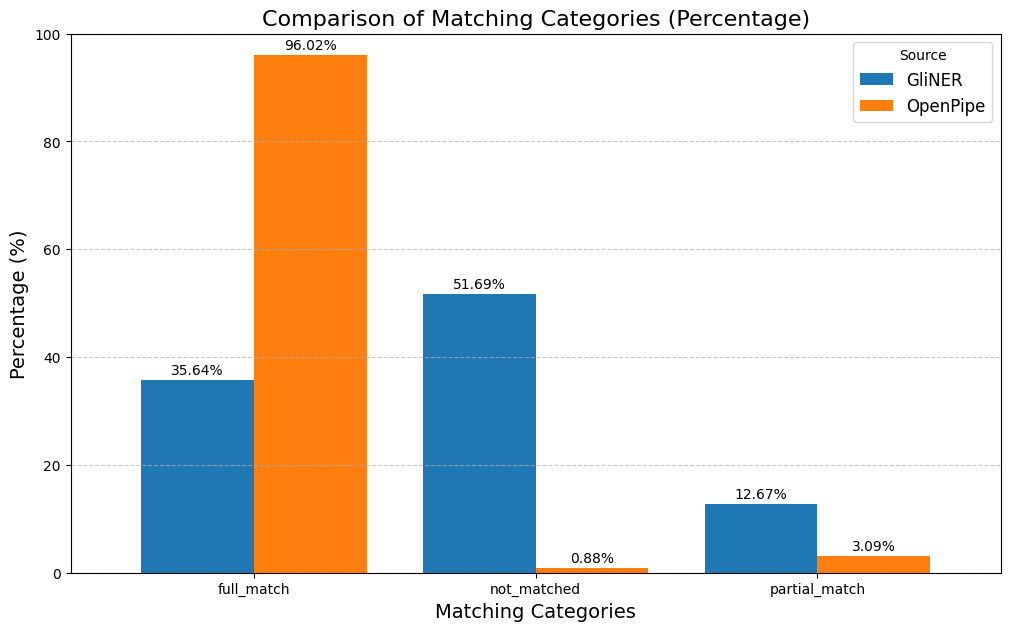

In [ ]:
plot_chunk_level_match(gt_text_df, drop_not_matched=False)

## Token Level Evaluation Of AI4Privacy Predictions

We will generate a **token-level DataFrame** containing tokens and their corresponding labels, begin-end indices then assign prediction labels to each token. Finally, we will align the labels to ensure a fair comparison. Since we need the indices of each token, we will tokenize it with Spark NLP tokenizer.

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.4.1 spark-nlp==5.5.3

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

# Tokenizer splits words in a relevant format for NLP
tokenizer = Tokenizer()\
    .setInputCols(["document"])\
    .setOutputCol("token")

nlpPipeline = Pipeline(
    stages=[
        documentAssembler,
        tokenizer
        ])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)

In [ ]:
spark_df = spark.createDataFrame(text_df)
sdf_result = model.transform(spark_df)

token_pred_df = sdf_result.select("doc_id", "text", F.explode(F.arrays_zip(sdf_result.token.begin,
                                                                           sdf_result.token.end,
                                                                           sdf_result.token.result,
                                                                          )).alias("cols"))\
                          .select("doc_id", "text", F.expr("cols['0']").alias("token_begin"),
                                                    F.expr("cols['1']").alias("token_end"),
                                                    F.expr("cols['2']").alias("token")).toPandas()

# aling end indexes with prediction indexes
token_pred_df.token_end = token_pred_df.token_end + 1
token_pred_df

,doc_id,text,token_begin,token_end,token
0,47139B,together a comprehensive guide on the benefit...,1,9,together
1,47139B,together a comprehensive guide on the benefit...,10,11,a
2,47139B,together a comprehensive guide on the benefit...,12,25,comprehensive
3,47139B,together a comprehensive guide on the benefit...,26,31,guide
4,47139B,together a comprehensive guide on the benefit...,32,34,on
...,...,...,...,...,...
6856,46778A,---------- Forwarded Email ----------\n\nSubje...,342,343,","
6857,46778A,---------- Forwarded Email ----------\n\nSubje...,344,348,2025
6858,46778A,---------- Forwarded Email ----------\n\nSubje...,351,355,Time
6859,46778A,---------- Forwarded Email ----------\n\nSubje...,355,356,:


#### Add Token Labels & Label Mapping

This code assigns chunk labels from four different sources (`ground_truth_df`, `openpipe_df` to tokens in `token_pred_df`. It determines which chunk label a token belongs to based on its begin position falling within the begin and end range of a chunk.

After the function executes:

The lists `gt_token_labels` and `openpipe_token_labels` contain the corresponding chunk labels for each token in `token_pred_df`.




In [ ]:
########## SİL BURAYI ###################

import pandas as pd

token_pred_df = pd.read_csv("ai4privacy_token_df.csv")
gt_text_df = pd.read_csv("ai4privacy_gt_text_gliner_openpipe_prediction_df.csv")
token_pred_df

,doc_id,text,token_begin,token_end,token
0,47139B,together a comprehensive guide on the benefit...,1,9,together
1,47139B,together a comprehensive guide on the benefit...,10,11,a
2,47139B,together a comprehensive guide on the benefit...,12,25,comprehensive
3,47139B,together a comprehensive guide on the benefit...,26,31,guide
4,47139B,together a comprehensive guide on the benefit...,32,34,on
...,...,...,...,...,...
6856,46778A,---------- Forwarded Email ----------\n\nSubje...,342,343,","
6857,46778A,---------- Forwarded Email ----------\n\nSubje...,344,348,2025
6858,46778A,---------- Forwarded Email ----------\n\nSubje...,351,355,Time
6859,46778A,---------- Forwarded Email ----------\n\nSubje...,355,356,:


In [ ]:
from tqdm import tqdm

def assign_token_labels(token_df, gt_chunk_df, openpipe_pred_df, gliner_pred_df):
    """
    Assigns chunk labels from ground truth and predictions to tokens based on position.

    Args:
        token_df (pd.DataFrame): DataFrame containing tokens with begin/end positions
        gt_chunk_df (pd.DataFrame): DataFrame containing ground truth chunks with begin/end positions
        pred_df (pd.DataFrame): DataFrame containing predicted chunks with begin/end positions

    Returns:
        tuple: Lists of ground truth and predicted token labels
    """
    gt_token_labels = []
    openpipe_pred_token_labels = []
    gliner_pred_token_labels = []

    docs = token_df.text.unique()

    for doc in tqdm(docs):
        gt_slice_df = gt_chunk_df[gt_chunk_df.text==doc].copy()
        pred_slice_df = openpipe_pred_df[openpipe_pred_df.text==doc].copy()
        gliner_slice_df = gliner_pred_df[gliner_pred_df.text==doc].copy()
        token_slice_df = token_df[token_df.text==doc].copy()

        for token_ind, token_row in token_slice_df.iterrows():
            # gt labels
            token_label="O"
            for gt_ind, gt_row in gt_slice_df.iterrows():
                if (gt_row.begin <= token_row.token_begin < gt_row.end):
                    token_label = gt_row.chunk_label
                    break
                else:
                    pass
            gt_token_labels.append(token_label)

            # openpipe prediction labels
            pred_label="O"
            for pred_ind, pred_row in pred_slice_df.iterrows():
                if (pred_row.begin <= token_row.token_begin < pred_row.end):
                    pred_label = pred_row.chunk_label
                    break
                else:
                    pass
            openpipe_pred_token_labels.append(pred_label)

            # gliner prediction labels
            gliner_pred_label="O"
            for gl_pred_ind, gl_pred_row in gliner_slice_df.iterrows():
                if (gl_pred_row.begin <= token_row.token_begin < gl_pred_row.end):
                    gliner_pred_label = gl_pred_row.chunk_label
                    break
                else:
                    pass
            gliner_pred_token_labels.append(gliner_pred_label)

    return gt_token_labels, openpipe_pred_token_labels, gliner_pred_token_labels

In [ ]:
gt_token_labels, openpipe_token_labels, gliner_token_labels = assign_token_labels(token_pred_df, gt_text_df, prediction_df, gliner_pred_df)

token_pred_df["token_label"] = gt_token_labels
token_pred_df["openpipe_token_label"] = openpipe_token_labels
token_pred_df["gliner_token_label"] = gliner_token_labels

In [ ]:
gt_text_df

,doc_id,text,privacy_mask,begin,end,chunk,chunk_label,openpipe_is_matched,openpipe_prediction,gliner_is_matched,gliner_prediction
0,47139B,together a comprehensive guide on the benefit...,"{'value': '12/03/1982', 'start': 107, 'end': 1...",107,117,12/03/1982,BOD,full_match,date_of_birth,not_matched,no_prediction
1,47139B,together a comprehensive guide on the benefit...,"{'value': 'Marinês', 'start': 235, 'end': 242,...",235,242,Marinês,GIVENNAME1,full_match,person_name,not_matched,no_prediction
2,47139B,together a comprehensive guide on the benefit...,"{'value': 'August 24th, 1986', 'start': 246, '...",246,263,"August 24th, 1986",BOD,full_match,date_of_birth,not_matched,no_prediction
3,47139B,together a comprehensive guide on the benefit...,"{'value': 'Dorinda', 'start': 271, 'end': 278,...",271,278,Dorinda,GIVENNAME1,full_match,person_name,partial_match,person_name
4,49394C,"hwatukee Foothills""\n },\n {...","{'value': 'AZ', 'start': 97, 'end': 99, 'label...",97,99,AZ,STATE,full_match,street_address,not_matched,no_prediction
...,...,...,...,...,...,...,...,...,...,...,...
674,48701A,```yaml\n- Parent Notice on Homework Policy No...,"{'value': '8:09 AM', 'start': 92, 'end': 99, '...",92,99,8:09 AM,TIME,full_match,date,not_matched,no_prediction
675,40802A,Subject: Welcome to Virtual Reality Classroom!...,"{'value': 'September 2nd, 1945', 'start': 329,...",329,348,"September 2nd, 1945",BOD,full_match,date_of_birth,full_match,date_of_birth
676,40802A,Subject: Welcome to Virtual Reality Classroom!...,"{'value': '2069-10-02T00:00:00', 'start': 371,...",371,390,2069-10-02T00:00:00,DATE,full_match,date,full_match,date
677,40802A,Subject: Welcome to Virtual Reality Classroom!...,"{'value': '375', 'start': 403, 'end': 406, 'la...",403,406,375,BUILDING,full_match,street_address,not_matched,no_prediction


In [ ]:
sorted(token_pred_df.token_label.unique())

['BOD',
 'BUILDING',
 'CITY',
 'COUNTRY',
 'DATE',
 'DRIVERLICENSE',
 'EMAIL',
 'GEOCOORD',
 'GIVENNAME1',
 'GIVENNAME2',
 'IDCARD',
 'IP',
 'LASTNAME1',
 'LASTNAME2',
 'LASTNAME3',
 'O',
 'PASS',
 'PASSPORT',
 'POSTCODE',
 'SECADDRESS',
 'SEX',
 'SOCIALNUMBER',
 'STATE',
 'STREET',
 'TEL',
 'TIME',
 'TITLE',
 'USERNAME']

In [ ]:
sorted(token_pred_df.openpipe_token_label.unique())

['O',
 'date',
 'date_of_birth',
 'email_address',
 'gender',
 'nationality',
 'organization_name',
 'other_id',
 'password',
 'person_name',
 'personal_id',
 'phone_number',
 'street_address']

Now, we will map the **ground truth (GT) labels** to the **prediction labels**, as the prediction labels are more generalized.

In [ ]:
token_pred_df.token_label = token_pred_df.token_label.replace({
    'DATE'         : 'date',
    'BOD'          : 'date_of_birth',
    'BUILDING'     : 'street_address',
    'CITY'         : 'street_address',
    'COUNTRY'      : 'street_address',
    'DRIVERLICENSE': 'personal_id',
    'EMAIL'        : 'email_address',
    'GEOCOORD'     : 'street_address',
    'GIVENNAME1'   : 'person_name',
    'GIVENNAME2'   : 'person_name',
    'IDCARD'       : 'personal_id',
    'IP'           : 'other_id',
    'LASTNAME1'    : 'person_name',
    'LASTNAME2'    : 'person_name',
    'LASTNAME3'    : 'person_name',
    'PASS'         : 'password',
    'PASSPORT'     : 'personal_id',
    'POSTCODE'     : 'street_address',
    'SECADDRESS'   : 'street_address',
    'SEX'          : 'gender',
    'SOCIALNUMBER' : 'personal_id',
    'STATE'        : 'street_address',
    'STREET'       : 'street_address',
    'TEL'          : 'phone_number',
    'TIME'         : 'date',
    'TITLE'        : 'person_name',
    'USERNAME'     : 'personal_id'
})

token_pred_df

,doc_id,text,token_begin,token_end,token,token_label,openpipe_token_label,gliner_token_label
0,47139B,together a comprehensive guide on the benefit...,1,9,together,O,O,O
1,47139B,together a comprehensive guide on the benefit...,10,11,a,O,O,O
2,47139B,together a comprehensive guide on the benefit...,12,25,comprehensive,O,O,O
3,47139B,together a comprehensive guide on the benefit...,26,31,guide,O,O,O
4,47139B,together a comprehensive guide on the benefit...,32,34,on,O,O,O
...,...,...,...,...,...,...,...,...
6856,46778A,---------- Forwarded Email ----------\n\nSubje...,342,343,",",date,date,date
6857,46778A,---------- Forwarded Email ----------\n\nSubje...,344,348,2025,date,date,date
6858,46778A,---------- Forwarded Email ----------\n\nSubje...,351,355,Time,O,O,O
6859,46778A,---------- Forwarded Email ----------\n\nSubje...,355,356,:,O,O,O


Let's review the labels in the predictions to see if we can merge any of them that are missing in the ground truth.

In [ ]:
[i for i in token_pred_df.openpipe_token_label.unique() if i not in token_pred_df.token_label.unique()]

['nationality', 'organization_name']

In [ ]:
[i for i in token_pred_df.gliner_token_label.unique() if i not in token_pred_df.token_label.unique()]

['nationality']

In [ ]:
token_pred_df[token_pred_df.openpipe_token_label=="nationality"]

,doc_id,text,token_begin,token_end,token,token_label,openpipe_token_label,gliner_token_label
562,46655,"{""SEX_id"": ""Male"", ""EMAIL_id"": ""asgadukardt25@...",166,172,United,street_address,nationality,nationality
563,46655,"{""SEX_id"": ""Male"", ""EMAIL_id"": ""asgadukardt25@...",173,180,Kingdom,street_address,nationality,nationality
999,47279B,"dent B (December/64, 20C@outlook.com, 994-37-2...",68,70,US,street_address,nationality,O
1399,50770A,The IP Waiver document for the given individua...,86,92,United,O,nationality,O
1400,50770A,The IP Waiver document for the given individua...,93,99,States,O,nationality,O
1553,44658C,6\n - Additional Address Information: Floor 4...,282,284,GB,street_address,nationality,nationality
2367,45576A,```docx\nPersonality Test Results\n\nDate: 06/...,110,112,GB,street_address,nationality,nationality
2835,52554C,yoress\n- **Passport Number:** 498886192\n- **...,55,61,United,street_address,nationality,nationality
2836,52554C,yoress\n- **Passport Number:** 498886192\n- **...,62,68,States,street_address,nationality,nationality
2873,52554C,yoress\n- **Passport Number:** 498886192\n- **...,228,230,US,street_address,nationality,O


In [ ]:
token_pred_df[token_pred_df.openpipe_token_label=="organization_name"]

,doc_id,text,token_begin,token_end,token,token_label,openpipe_token_label,gliner_token_label
713,47599C,you are a seasoned educator seeking career ad...,134,146,EducationNow,O,organization_name,O
1497,48689C,recommend refining the conclusion to ensure a ...,400,409,Education,O,organization_name,O
1498,48689C,recommend refining the conclusion to ensure a ...,410,420,Department,O,organization_name,O
2509,42282A,**Podcast Episode Transcripts - School Finance...,150,158,Educasts,O,organization_name,O
2818,49797C,"16-8789\n - Address: 494, Deer Spring, Irvin...",401,410,Pediatric,O,organization_name,O
2819,49797C,"16-8789\n - Address: 494, Deer Spring, Irvin...",411,421,Hematology,O,organization_name,O
2820,49797C,"16-8789\n - Address: 494, Deer Spring, Irvin...",422,432,Department,O,organization_name,O
3257,44511A,"""Comment Section - Video Title: ""Top 10 Amazin...",98,106,U4647732,personal_id,organization_name,person_name
3311,44511A,"""Comment Section - Video Title: ""Top 10 Amazin...",381,390,AO84661WZ,personal_id,organization_name,person_name
3590,40954B,"- Address: [369, Beaumont Hall Lane, Saint Al...",349,354,Grant,O,organization_name,O


We will merge the **`nationality`** label with the **`street_address`** and convert the **`organization_name`** labels to **`O`** in order to remove them.

In [ ]:
token_pred_df.openpipe_token_label = token_pred_df.openpipe_token_label.replace({"nationality":"street_address", "organization_name":"O"})
token_pred_df.gliner_token_label = token_pred_df.gliner_token_label.replace({"nationality":"street_address"})

token_pred_df

,doc_id,text,token_begin,token_end,token,token_label,openpipe_token_label,gliner_token_label
0,47139B,together a comprehensive guide on the benefit...,1,9,together,O,O,O
1,47139B,together a comprehensive guide on the benefit...,10,11,a,O,O,O
2,47139B,together a comprehensive guide on the benefit...,12,25,comprehensive,O,O,O
3,47139B,together a comprehensive guide on the benefit...,26,31,guide,O,O,O
4,47139B,together a comprehensive guide on the benefit...,32,34,on,O,O,O
...,...,...,...,...,...,...,...,...
6856,46778A,---------- Forwarded Email ----------\n\nSubje...,342,343,",",date,date,date
6857,46778A,---------- Forwarded Email ----------\n\nSubje...,344,348,2025,date,date,date
6858,46778A,---------- Forwarded Email ----------\n\nSubje...,351,355,Time,O,O,O
6859,46778A,---------- Forwarded Email ----------\n\nSubje...,355,356,:,O,O,O


Now, we will generate a classification report to evaluate the performance of **OpenPipe's PII-Redact** on the **AI4Privacy PII-masking-300k dataset** at the **token level**.

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(token_pred_df["token_label"], token_pred_df["openpipe_token_label"]))

                precision    recall  f1-score   support

             O       1.00      1.00      1.00      6053
          date       0.96      0.94      0.95       120
 date_of_birth       1.00      0.98      0.99        59
 email_address       1.00      1.00      1.00        31
        gender       1.00      1.00      1.00        24
      other_id       1.00      1.00      1.00        27
      password       1.00      1.00      1.00        25
   person_name       0.86      1.00      0.93        76
   personal_id       1.00      0.94      0.97       188
  phone_number       1.00      1.00      1.00        29
street_address       0.98      0.99      0.98       229

      accuracy                           0.99      6861
     macro avg       0.98      0.99      0.98      6861
  weighted avg       1.00      0.99      0.99      6861



In [ ]:
print(classification_report(token_pred_df["token_label"], token_pred_df["gliner_token_label"]))

                precision    recall  f1-score   support

             O       0.93      0.98      0.95      6053
          date       0.55      0.33      0.41       120
 date_of_birth       1.00      0.88      0.94        59
 email_address       0.83      0.94      0.88        31
        gender       0.81      0.71      0.76        24
      other_id       0.00      0.00      0.00        27
      password       0.96      0.88      0.92        25
   person_name       0.49      0.41      0.45        76
   personal_id       0.71      0.03      0.05       188
  phone_number       0.79      0.93      0.86        29
street_address       0.66      0.52      0.58       229

      accuracy                           0.91      6861
     macro avg       0.70      0.60      0.62      6861
  weighted avg       0.90      0.91      0.90      6861



### PHI Or Non-PHI

The de-identification task is crucial in ensuring the privacy of sensitive data. In this context, the primary focus is not on the specific labels of PHI entities but on whether they are successfully detected. When we evaluate the results based on whether the entities are classified as PHI or non-PHI, the outcomes are as follows.

In [ ]:
phi_token_df = token_pred_df.copy()
phi_token_df.token_label = ["PHI" if i != "O" else "Non-PHI" for i in phi_token_df.token_label]
phi_token_df.openpipe_token_label = ["PHI" if i != "O" else "Non-PHI" for i in phi_token_df.openpipe_token_label]
phi_token_df.gliner_token_label = ["PHI" if i != "O" else "Non-PHI" for i in phi_token_df.gliner_token_label]

phi_token_df

,doc_id,text,token_begin,token_end,token,token_label,openpipe_token_label,gliner_token_label
0,47139B,together a comprehensive guide on the benefit...,1,9,together,Non-PHI,Non-PHI,Non-PHI
1,47139B,together a comprehensive guide on the benefit...,10,11,a,Non-PHI,Non-PHI,Non-PHI
2,47139B,together a comprehensive guide on the benefit...,12,25,comprehensive,Non-PHI,Non-PHI,Non-PHI
3,47139B,together a comprehensive guide on the benefit...,26,31,guide,Non-PHI,Non-PHI,Non-PHI
4,47139B,together a comprehensive guide on the benefit...,32,34,on,Non-PHI,Non-PHI,Non-PHI
...,...,...,...,...,...,...,...,...
6856,46778A,---------- Forwarded Email ----------\n\nSubje...,342,343,",",PHI,PHI,PHI
6857,46778A,---------- Forwarded Email ----------\n\nSubje...,344,348,2025,PHI,PHI,PHI
6858,46778A,---------- Forwarded Email ----------\n\nSubje...,351,355,Time,Non-PHI,Non-PHI,Non-PHI
6859,46778A,---------- Forwarded Email ----------\n\nSubje...,355,356,:,Non-PHI,Non-PHI,Non-PHI


Let's get classification report for the results.

In [ ]:
from sklearn.metrics import classification_report

print("Open Pipe:")
print(classification_report(phi_token_df["token_label"], phi_token_df["openpipe_token_label"]))

Open Pipe:
              precision    recall  f1-score   support

     Non-PHI       1.00      1.00      1.00      6053
         PHI       0.98      0.98      0.98       808

    accuracy                           1.00      6861
   macro avg       0.99      0.99      0.99      6861
weighted avg       1.00      1.00      1.00      6861



In [ ]:
print(classification_report(phi_token_df["token_label"], phi_token_df["gliner_token_label"]))

              precision    recall  f1-score   support

     Non-PHI       0.93      0.98      0.95      6053
         PHI       0.74      0.45      0.56       808

    accuracy                           0.92      6861
   macro avg       0.84      0.71      0.76      6861
weighted avg       0.91      0.92      0.91      6861



# Performance Test On Clinical Dataset

Based on the evaluation results of PII-Redact on the AI4Privacy PII-masking-300k dataset, it performs exceptionally well on unstructured datasets. Now, we will assess its performance on a real-world clinical dataset.

For this benchmark, we will use 48 open-source documents annotated by domain experts from John Snow Labs. The annotations focused on the extraction of `IDNUM`, `LOCATION`, `DATE`, `AGE`, `NAME`, and `CONTACT` entities because these labels represent critical personal information that is commonly targeted for deidentification in various healthcare. These labels are typically associated with sensitive aspects of a person’s identity and are often required to be removed or anonymized in compliance with regulations like HIPAA or GDPR.

***NOTE:** This notebook includes results for the entire dataset; however, only a randomly selected sample of 10 rows will be displayed. If you would like access to the full dataset, please contact **support@johnsnowlabs.com***.  

In [ ]:
# Downloading sample datasets.
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/refs/heads/master/tutorials/academic/DeIdentification_Benchmarks_Text2Story2025/deidentification_benchmark_ground_truth_48_doc.csv

In [ ]:
import pandas as pd

ground_truth_df = pd.read_csv("deidentification_benchmark_ground_truth_48_doc.csv")
ground_truth_df

,doc_id,text,begin,end,chunk,chunk_label
0,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA .\nUnsigned\nDIS\nReport Status :\nUnsigned\nADMISSION DATE :\n2-5-94\nDISCHARGE DATE :\n4-2-94\nPRIN...,1,10,957770228,IDNUM
1,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA .\nUnsigned\nDIS\nReport Status :\nUnsigned\nADMISSION DATE :\n2-5-94\nDISCHARGE DATE :\n4-2-94\nPRIN...,11,14,FIH,LOCATION
2,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA .\nUnsigned\nDIS\nReport Status :\nUnsigned\nADMISSION DATE :\n2-5-94\nDISCHARGE DATE :\n4-2-94\nPRIN...,15,22,0408267,IDNUM
3,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA .\nUnsigned\nDIS\nReport Status :\nUnsigned\nADMISSION DATE :\n2-5-94\nDISCHARGE DATE :\n4-2-94\nPRIN...,23,33,46769/5v7d,IDNUM
4,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA .\nUnsigned\nDIS\nReport Status :\nUnsigned\nADMISSION DATE :\n2-5-94\nDISCHARGE DATE :\n4-2-94\nPRIN...,34,40,237890,IDNUM
...,...,...,...,...,...,...
1474,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSITY OF MD CHARLES REGIONAL MEDICAL CENTER\n\nNIX SPECIALTY HEALTH CENTER\n\nCALIFORNIA Eupora ,\n\nRecords Coversheet\n\nDiego Foy\n\nPatient Name : 6...",559,568,Lake Erin,LOCATION
1475,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSITY OF MD CHARLES REGIONAL MEDICAL CENTER\n\nNIX SPECIALTY HEALTH CENTER\n\nCALIFORNIA Eupora ,\n\nRecords Coversheet\n\nDiego Foy\n\nPatient Name : 6...",571,577,ALASKA,LOCATION
1476,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSITY OF MD CHARLES REGIONAL MEDICAL CENTER\n\nNIX SPECIALTY HEALTH CENTER\n\nCALIFORNIA Eupora ,\n\nRecords Coversheet\n\nDiego Foy\n\nPatient Name : 6...",578,583,38720,LOCATION
1477,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSITY OF MD CHARLES REGIONAL MEDICAL CENTER\n\nNIX SPECIALTY HEALTH CENTER\n\nCALIFORNIA Eupora ,\n\nRecords Coversheet\n\nDiego Foy\n\nPatient Name : 6...",590,602,966.255.9888,CONTACT


We will follow the same approach used in the AI4Privacy dataset benchmark: obtaining predictions from **OpenPipe's PII-Redact** and evaluating its performance at both the **chunk-level** and **token-level**.

In [ ]:
text_df = ground_truth_df[["doc_id", "text"]].drop_duplicates().reset_index(drop=True)
text_df

,doc_id,text
0,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA .\nUnsigned\nDIS\nReport Status :\nUnsigned\nADMISSION DATE :\n2-5-94\nDISCHARGE DATE :\n4-2-94\nPRIN...
1,2,"\n291181306\nFIH\n0231078\n718719\n9555422\n03/11/2002 12:00:00 AM\nDischarge Summary\nSigned\nDIS\nReport Status :\nSigned\nDISCHARGE SUMMARY NAME :\nGETZZOCHTLAND , SYNNANI F\nUNIT NUMBER :\n451..."
2,3,"\n425093222\nPRGH\n74052207\n446315\n3/14/1998 12:00:00 AM\nLEUKEMIA , NEUTROPENIA\nSigned\nDIS\nAdmission Date :\n03/14/1998\nReport Status :\nSigned\nDischarge Date :\n04/17/1998\nSERVICE :\nOnc..."
3,4,\n229937784\nFIH\n8765992\n87919/3984\n754719\n12/6/1993 12:00:00 AM\nUNSTABLE ANGINA .\nUnsigned\nDIS\nReport Status :\nUnsigned\nADMISSION DATE :\n12-6-93\nDISCHARGE DATE :\n12-9-93\nIDENTIFYING...
4,5,\n305265793\nFIH\n2833679\n88326/x91o\n688470\n10/20/1992 12:00:00 AM\nDischarge Summary\nUnsigned\nDIS\nReport Status :\nUnsigned\nADMISSION DATE :\n10/20/92\nDISCHARGE DATE :\n11/6/92\nCHIEF COM...
5,6,"\n928175728 ELMVH\n73813877\n374382\n5/17/2000 12:00:00 AM\npregnancy\nDIS\nAdmission Date :\n05/17/2000\nReport Status :\nDischarge Date :\n05/22/2000\n****** DISCHARGE ORDERS ******\nDUHETLAND ,..."
6,7,"\n506243692\nFIH\n6305145\n457846\n597698\n9/11/2002 12:00:00 AM\nDischarge Summary\nSigned\nDIS\nReport Status :\nSigned\nDISCHARGE SUMMARY NAME :\nNERTLAND , ELRO\nUNIT NUMBER :\n413-18-46\nADMI..."
7,8,\n305265793\nFIH\n2833679\n23424/1931\n653207\n5/30/1994 12:00:00 AM\n(1) STAGE IIIC OVARIAN CARCINOMA .\nUnsigned\nDIS\nReport Status :\nUnsigned\nADMISSION DATE :\n05/30/94\nDISCHARGE DATE :\n06...
8,9,\n333145593\nFIH\n9229891\n50096/c65m\n571634\n12/5/1993 12:00:00 AM\nDischarge Summary\nUnsigned\nDIS\nReport Status :\nUnsigned\nADMISSION DATE :\n12/05/93\nDISCHARGE DATE :\n12/17/93\nCAUSE OF ...
9,10,\n305265793\nFIH\n2833679\n61793/5e2q\n901693\n09/02/1992 12:00:00 AM\nSTAGE IIIC OVARIAN CARCINOMA .\nUnsigned\nDIS\nReport Status :\nUnsigned\nADMISSION DATE :\n09-02-92\nDISCHARGE DATE :\n9-14-...


### Document Splitting

In [ ]:
import json
import os

from google.colab import files

if 'spark_jsl.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_jsl.json')

with open('spark_jsl.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)
os.environ.update(license_keys)

Saving public553_jsl553.json to public553_jsl553.json


In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.4.1 spark-nlp==$PUBLIC_VERSION


# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 635.7/635.7 kB 44.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-spark-connect 0.5.2 requires pyspark>=3.5, but you have pyspark 3.4.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 391.8/391.8 kB 730.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import json
import os

import sparknlp
import sparknlp_jsl

from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp_jsl.pipeline_tracer import PipelineTracer
from sparknlp_jsl.pipeline_output_parser import PipelineOutputParser

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline,PipelineModel

import pandas as pd
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')

params = {"spark.driver.memory":"16G",
          "spark.kryoserializer.buffer.max":"2000M",
          "spark.driver.maxResultSize":"2000M"}

print("Spark NLP Version :", sparknlp.version())
print("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark = sparknlp_jsl.start(license_keys['SECRET'],params=params)

spark

Spark NLP Version : 5.5.3
Spark NLP_JSL Version : 5.5.3


In [ ]:
document_assembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

document_splitter = InternalDocumentSplitter()\
    .setInputCols("document")\
    .setOutputCol("splits")\
    .setSplitMode("recursive")\
    .setChunkSize(1000)\
    .setExplodeSplits(True)\
    .setPatternsAreRegex(False)\
    .setSplitPatterns(["\n\n", "\n", "\. ", " "])\
    .setKeepSeparators(False)\
    .setTrimWhitespace(False)
    #.setChunkOverlap(3)\ default 0

pipeline = Pipeline().setStages([
    document_assembler,
     document_splitter
])

empty_df = spark.createDataFrame([['']]).toDF('text')

pipeline_model = pipeline.fit(empty_df)

In [ ]:
spark_df = spark.createDataFrame(text_df)
results =  pipeline_model.transform(spark_df)

In [ ]:
results.show(3)

+------+--------------------+--------------------+--------------------+
|doc_id|                text|            document|              splits|
+------+--------------------+--------------------+--------------------+
|     1|\n957770228\nFIH\...|[{document, 0, 78...|[{document, 1, 98...|
|     1|\n957770228\nFIH\...|[{document, 0, 78...|[{document, 981, ...|
|     1|\n957770228\nFIH\...|[{document, 0, 78...|[{document, 1956,...|
+------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [ ]:
pd.set_option('display.max_colwidth', 100)

result_df = results.select("doc_id", "text", F.explode(F.arrays_zip(results.splits.begin,
                                                                    results.splits.end,
                                                                    results.splits.result,
                                                                    results.splits.metadata)).alias("cols"))\
                   .select("doc_id", "text", F.expr("cols['3']['document']").alias("split_id"),
                           F.expr("cols['0']").alias("split_begin"),
                           F.expr("cols['1']").alias("split_end"),
                           F.expr("cols['2']").alias("split")).toPandas()

result_df

,doc_id,text,split_id,split_begin,split_end,split
0,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA ....,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA .\n...
1,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA ....,1,981,1955,The patient was initially diagnosed in 1978 with atypical small cell carcinoma of the lung and t...
2,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA ....,2,1956,2953,A barium swallow prior to admission showed the presence of a tracheoesophageal fistula with entr...
3,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA ....,3,2954,3937,The lungs showed mild inspiratory wheeze and moderate expiratory wheezes .\nBreath sounds are pr...
4,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA ....,4,3938,4867,"She then had a transhiatal esophagectomy which was partial , and a substernal gastric interposit..."
...,...,...,...,...,...,...
285,45,Email : Hobbes@yahoo.com\n\nPhone : ( 010 ) 364-7353\n\nPhone : +13103778288\n\nFax : +364692595...,1,932,1455,At 23:18 he was neurologically assessed by Dr . Anastacio Balm and was HD stable with normal vit...
286,46,----- % Date : 8/8/68\n\nX *: I ; * • ■ Sample No . 5031___ — .*\n\n• * Original request made by...,0,0,985,----- % Date : 8/8/68\n\nX *: I ; * • ■ Sample No . 5031___ — .*\n\n• * Original request made by...
287,46,----- % Date : 8/8/68\n\nX *: I ; * • ■ Sample No . 5031___ — .*\n\n• * Original request made by...,1,987,1465,"Laboratory A n a l ysis^ I "" ' /***• * 7 ' ^ ^\n\nTars and Nicotine , Taste Panel , Burning Time..."
288,47,"critical result hand delivered to manual self , rn 24.9.23 @ 1203 by ho second sample requested ...",0,0,757,"critical result hand delivered to manual self , rn 24.9.23 @ 1203 by ho second sample requested ..."


In [ ]:
result_df.to_csv("gt_split_df.csv", index=False)

## OpenPipe PII-Redact

In [ ]:
import pandas as pd

result_df = pd.read_csv("gt_split_df.csv")
result_df

,doc_id,text,split_id,split_begin,split_end,split
0,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA ....,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA .\n...
1,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA ....,1,981,1955,The patient was initially diagnosed in 1978 with atypical small cell carcinoma of the lung and t...
2,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA ....,2,1956,2953,A barium swallow prior to admission showed the presence of a tracheoesophageal fistula with entr...
3,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA ....,3,2954,3937,The lungs showed mild inspiratory wheeze and moderate expiratory wheezes .\nBreath sounds are pr...
4,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA ....,4,3938,4867,"She then had a transhiatal esophagectomy which was partial , and a substernal gastric interposit..."
...,...,...,...,...,...,...
285,45,Email : Hobbes@yahoo.com\n\nPhone : ( 010 ) 364-7353\n\nPhone : +13103778288\n\nFax : +364692595...,1,932,1455,At 23:18 he was neurologically assessed by Dr . Anastacio Balm and was HD stable with normal vit...
286,46,----- % Date : 8/8/68\n\nX *: I ; * • ■ Sample No . 5031___ — .*\n\n• * Original request made by...,0,0,985,----- % Date : 8/8/68\n\nX *: I ; * • ■ Sample No . 5031___ — .*\n\n• * Original request made by...
287,46,----- % Date : 8/8/68\n\nX *: I ; * • ■ Sample No . 5031___ — .*\n\n• * Original request made by...,1,987,1465,"Laboratory A n a l ysis^ I "" ' /***• * 7 ' ^ ^\n\nTars and Nicotine , Taste Panel , Burning Time..."
288,47,"critical result hand delivered to manual self , rn 24.9.23 @ 1203 by ho second sample requested ...",0,0,757,"critical result hand delivered to manual self , rn 24.9.23 @ 1203 by ho second sample requested ..."


In [ ]:
%%time

documents = result_df.split.to_list()
tagged_documents = tag_pii_in_documents(documents, mode=PIIHandlingMode.TAG)

In [ ]:
openpipe_df = result_df.copy()
openpipe_df["predictions"] = tagged_documents
openpipe_df

,doc_id,text,split_id,split_begin,split_end,split,predictions
0,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA ....,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA .\n...,957770228\nFIH\n<PII:personal_id>0408267</PII:personal_id>\n<PII:password>46769/5v7d</PII:passwo...
1,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA ....,1,981,1955,The patient was initially diagnosed in 1978 with atypical small cell carcinoma of the lung and t...,The patient was initially diagnosed in 1978 with atypical small cell carcinoma of the lung and t...
2,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA ....,2,1956,2953,A barium swallow prior to admission showed the presence of a tracheoesophageal fistula with entr...,A barium swallow prior to admission showed the presence of a tracheoesophageal fistula with entr...
3,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA ....,3,2954,3937,The lungs showed mild inspiratory wheeze and moderate expiratory wheezes .\nBreath sounds are pr...,The lungs showed mild inspiratory wheeze and moderate expiratory wheezes .\nBreath sounds are pr...
4,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA ....,4,3938,4867,"She then had a transhiatal esophagectomy which was partial , and a substernal gastric interposit...","She then had a transhiatal esophagectomy which was partial , and a substernal gastric interposit..."
...,...,...,...,...,...,...,...
285,45,Email : Hobbes@yahoo.com\n\nPhone : ( 010 ) 364-7353\n\nPhone : +13103778288\n\nFax : +364692595...,1,932,1455,At 23:18 he was neurologically assessed by Dr . Anastacio Balm and was HD stable with normal vit...,At <PII:date>23:18</PII:date> he was neurologically assessed by Dr . <PII:person_name>Anastacio ...
286,46,----- % Date : 8/8/68\n\nX *: I ; * • ■ Sample No . 5031___ — .*\n\n• * Original request made by...,0,0,985,----- % Date : 8/8/68\n\nX *: I ; * • ■ Sample No . 5031___ — .*\n\n• * Original request made by...,----- % Date : <PII:date>8/8/68</PII:date>\n\nX *: I ; * • ■ Sample No . 5031___ — .*\n\n• * Ori...
287,46,----- % Date : 8/8/68\n\nX *: I ; * • ■ Sample No . 5031___ — .*\n\n• * Original request made by...,1,987,1465,"Laboratory A n a l ysis^ I "" ' /***• * 7 ' ^ ^\n\nTars and Nicotine , Taste Panel , Burning Time...","Laboratory A n a l ysis^ I "" ' /***• * 7 ' ^ ^\n\nTars and Nicotine , Taste Panel , Burning Time..."
288,47,"critical result hand delivered to manual self , rn 24.9.23 @ 1203 by ho second sample requested ...",0,0,757,"critical result hand delivered to manual self , rn 24.9.23 @ 1203 by ho second sample requested ...","critical result hand delivered to manual self , <PII:date>rn</PII:date> 24.9.23 @ 1203 by <PII:p..."


Let's see how the predictions look like.

In [ ]:
print(openpipe_df.iloc[0].predictions)

957770228
FIH
<PII:personal_id>0408267</PII:personal_id>
<PII:password>46769/5v7d</PII:password>
<PII:personal_id>237890</PII:personal_id>
<PII:date>2/5/1994</PII:date> <PII:date>12:00:00 AM</PII:date>
TRACHEOESOPHAGEAL FISTULA .
Unsigned
DIS
Report Status :
Unsigned
ADMISSION DATE :
2-5-94
DISCHARGE DATE :
4-2-94
PRINCIPAL DIAGNOSIS :
Tracheoesophageal fistula .
ASSOCIATED DIAGNOSIS :
Diabetes mellitus , pneumonia , sepsis , respiratory failure , pleural effusion , postoperative encephalopathy , postoperative myocardial infarction , and thrombocytopenia .
SPECIAL PROCEDURES AND OPERATIONS :
February 6 , 1994 , rigid bronchoscopy with biopsy and upper gastrointestinal endoscopy .
ASSOCIATED PROCEDURES :
On February 10 , 1994 , flexible bronchoscopy , flexible esophagoscopy , rigid bronchoscopy , transhiatal esophagectomy ( partial ) , substernal gastric interposition and jejunostomy .
Multiple bronchoscopies , chest tube insertion .
HISTORY OF PRESENT ILLNESS :
The patient was a 71 yea

In [ ]:
# save results
openpipe_df.to_csv("openpipe_split_df.csv", index=False)

**Get Entities From Tagged Text**

The texts were deidentified by adding entity tags like `<PII:personal_id>0408267</PII:personal_id>`, so we will get the entities, their labels, begin and end indices using the following function.

In [ ]:
openpipe_df = pd.read_csv("openpipe_split_df.csv")

In [ ]:
# Apply get_entities to the predictions column
openpipe_df['extracted_entities'] = openpipe_df['predictions'].apply(get_entities_from_predictions)
openpipe_df

,doc_id,text,split_id,split_begin,split_end,split,predictions,extracted_entities
0,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,957770228\nFIH\n<PII:personal_id>0408267</PII:...,"[{'entity': '0408267', 'label': 'personal_id',..."
1,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,1,981,1955,The patient was initially diagnosed in 1978 wi...,The patient was initially diagnosed in 1978 wi...,[]
2,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,2,1956,2953,A barium swallow prior to admission showed the...,A barium swallow prior to admission showed the...,[]
3,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,3,2954,3937,The lungs showed mild inspiratory wheeze and m...,The lungs showed mild inspiratory wheeze and m...,"[{'entity': 'February 5 , 199', 'label': 'date..."
4,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,4,3938,4867,She then had a transhiatal esophagectomy which...,She then had a transhiatal esophagectomy which...,[]
...,...,...,...,...,...,...,...,...
285,45,Email : Hobbes@yahoo.com\n\nPhone : ( 010 ) 36...,1,932,1455,At 23:18 he was neurologically assessed by Dr ...,At <PII:date>23:18</PII:date> he was neurologi...,"[{'entity': '23:18', 'label': 'date', 'start':..."
286,46,----- % Date : 8/8/68\n\nX *: I ; * • ■ Sample...,0,0,985,----- % Date : 8/8/68\n\nX *: I ; * • ■ Sample...,----- % Date : <PII:date>8/8/68</PII:date>\n\n...,"[{'entity': '8/8/68', 'label': 'date', 'start'..."
287,46,----- % Date : 8/8/68\n\nX *: I ; * • ■ Sample...,1,987,1465,"Laboratory A n a l ysis^ I "" ' /***• * 7 ' ^ ^...","Laboratory A n a l ysis^ I "" ' /***• * 7 ' ^ ^...",[]
288,47,critical result hand delivered to manual self ...,0,0,757,critical result hand delivered to manual self ...,critical result hand delivered to manual self ...,"[{'entity': 'rn', 'label': 'date', 'start': 48..."


In [ ]:
openpipe_df = openpipe_df.explode("extracted_entities").reset_index(drop=True)
openpipe_df

,doc_id,text,split_id,split_begin,split_end,split,predictions,extracted_entities
0,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,957770228\nFIH\n<PII:personal_id>0408267</PII:...,"{'entity': '0408267', 'label': 'personal_id', ..."
1,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,957770228\nFIH\n<PII:personal_id>0408267</PII:...,"{'entity': '46769/5v7d', 'label': 'password', ..."
2,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,957770228\nFIH\n<PII:personal_id>0408267</PII:...,"{'entity': '237890', 'label': 'personal_id', '..."
3,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,957770228\nFIH\n<PII:personal_id>0408267</PII:...,"{'entity': '2/5/1994', 'label': 'date', 'start..."
4,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,957770228\nFIH\n<PII:personal_id>0408267</PII:...,"{'entity': '12:00:00 AM', 'label': 'date', 'st..."
...,...,...,...,...,...,...,...,...
996,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",0,0,634,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",6509414988 <PII:person_name>Theophilus</PII:pe...,"{'entity': 'Diego Foy', 'label': 'person_name'..."
997,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",0,0,634,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",6509414988 <PII:person_name>Theophilus</PII:pe...,"{'entity': '6509414988', 'label': 'personal_id..."
998,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",0,0,634,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",6509414988 <PII:person_name>Theophilus</PII:pe...,"{'entity': '2/16/1941', 'label': 'date_of_birt..."
999,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",0,0,634,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",6509414988 <PII:person_name>Theophilus</PII:pe...,"{'entity': 'Not', 'label': 'person_name', 'sta..."


**In some of the splits, the model couldn't extract PHI entities. So we will drop those rows.**

In [ ]:
openpipe_df = openpipe_df[~openpipe_df.extracted_entities.isna()].reset_index(drop=True)
openpipe_df

,doc_id,text,split_id,split_begin,split_end,split,predictions,extracted_entities
0,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,957770228\nFIH\n<PII:personal_id>0408267</PII:...,"{'entity': '0408267', 'label': 'personal_id', ..."
1,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,957770228\nFIH\n<PII:personal_id>0408267</PII:...,"{'entity': '46769/5v7d', 'label': 'password', ..."
2,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,957770228\nFIH\n<PII:personal_id>0408267</PII:...,"{'entity': '237890', 'label': 'personal_id', '..."
3,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,957770228\nFIH\n<PII:personal_id>0408267</PII:...,"{'entity': '2/5/1994', 'label': 'date', 'start..."
4,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,957770228\nFIH\n<PII:personal_id>0408267</PII:...,"{'entity': '12:00:00 AM', 'label': 'date', 'st..."
...,...,...,...,...,...,...,...,...
902,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",0,0,634,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",6509414988 <PII:person_name>Theophilus</PII:pe...,"{'entity': 'Diego Foy', 'label': 'person_name'..."
903,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",0,0,634,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",6509414988 <PII:person_name>Theophilus</PII:pe...,"{'entity': '6509414988', 'label': 'personal_id..."
904,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",0,0,634,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",6509414988 <PII:person_name>Theophilus</PII:pe...,"{'entity': '2/16/1941', 'label': 'date_of_birt..."
905,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",0,0,634,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",6509414988 <PII:person_name>Theophilus</PII:pe...,"{'entity': 'Not', 'label': 'person_name', 'sta..."


**Now we will add the new columns to the dataframe.**

In [ ]:
import pandas as pd
def add_clinical_entity_columns(df, key_chunk="entity"):
  return pd.DataFrame({
      'doc_id': df['doc_id'],
      'text': df['text'],
      'split_id': df['split_id'],
      'split_begin': df['split_begin'],
      'split_end': df['split_end'],
      'split': df['split'],
      'begin': [entity_dict.get('start') if isinstance(entity_dict, dict) else None for entity_dict in df['extracted_entities']],
      'end': [entity_dict.get('end') if isinstance(entity_dict, dict) else None for entity_dict in df['extracted_entities']],
      'chunk': [entity_dict.get(key_chunk) if isinstance(entity_dict, dict) else None for entity_dict in df['extracted_entities']],
      'chunk_label': [entity_dict.get('label') if isinstance(entity_dict, dict) else None for entity_dict in df['extracted_entities']],
  })

In [ ]:
openpipe_df = add_clinical_entity_columns(openpipe_df)
openpipe_df

,doc_id,text,split_id,split_begin,split_end,split,begin,end,chunk,chunk_label
0,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,14,21,0408267,personal_id
1,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,22,32,46769/5v7d,password
2,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,33,39,237890,personal_id
3,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,40,48,2/5/1994,date
4,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,49,60,12:00:00 AM,date
...,...,...,...,...,...,...,...,...,...,...
902,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",0,0,634,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",155,164,Diego Foy,person_name
903,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",0,0,634,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",181,191,6509414988,personal_id
904,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",0,0,634,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",221,230,2/16/1941,date_of_birth
905,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",0,0,634,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",260,263,Not,person_name


### Label Mapping

We will map the prediction labels with the ground truths.

In [ ]:
ground_truth_df.chunk_label.value_counts()

,count
chunk_label,
DATE,582
NAME,380
LOCATION,236
IDNUM,185
CONTACT,49
AGE,47


In [ ]:
openpipe_df.chunk_label.value_counts()

,count
chunk_label,
person_name,333
date,247
personal_id,146
date_of_birth,70
organization_name,48
street_address,41
password,12
phone_number,6
email_address,3


In [ ]:
openpipe_df.chunk_label = openpipe_df.chunk_label.replace("person_name", "NAME")
openpipe_df.chunk_label = openpipe_df.chunk_label.replace("street_address", "LOCATION")
openpipe_df.chunk_label = openpipe_df.chunk_label.apply(lambda x: "IDNUM" if x in ['personal_id', 'password'] else x)
openpipe_df.chunk_label = openpipe_df.chunk_label.apply(lambda x: "CONTACT" if x in ['phone_number', 'email_address'] else x)
openpipe_df.chunk_label = openpipe_df.chunk_label.apply(lambda x: "DATE" if x in ['date_of_birth', 'date'] else x)
openpipe_df = openpipe_df[~openpipe_df.chunk_label.isin(["organization_name", "gender"])].reset_index(drop=True)
openpipe_df

,doc_id,text,split_id,split_begin,split_end,split,begin,end,chunk,chunk_label
0,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,14,21,0408267,IDNUM
1,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,22,32,46769/5v7d,IDNUM
2,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,33,39,237890,IDNUM
3,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,40,48,2/5/1994,DATE
4,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,49,60,12:00:00 AM,DATE
...,...,...,...,...,...,...,...,...,...,...
853,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",0,0,634,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",155,164,Diego Foy,NAME
854,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",0,0,634,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",181,191,6509414988,IDNUM
855,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",0,0,634,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",221,230,2/16/1941,DATE
856,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",0,0,634,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",260,263,Not,NAME


In [ ]:
openpipe_df.chunk_label.value_counts()

,count
chunk_label,
NAME,333
DATE,317
IDNUM,158
LOCATION,41
CONTACT,9


### Set Begin-End Indices

We will check if the begin-end positions are correct. If not we will fix them.

In [ ]:
openpipe_df.begin = openpipe_df.begin + openpipe_df.split_begin
openpipe_df.end = openpipe_df.end + openpipe_df.split_begin
openpipe_df

,doc_id,text,split_id,split_begin,split_end,split,begin,end,chunk,chunk_label
0,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,15,22,0408267,IDNUM
1,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,23,33,46769/5v7d,IDNUM
2,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,34,40,237890,IDNUM
3,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,41,49,2/5/1994,DATE
4,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,50,61,12:00:00 AM,DATE
...,...,...,...,...,...,...,...,...,...,...
853,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",0,0,634,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",155,164,Diego Foy,NAME
854,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",0,0,634,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",181,191,6509414988,IDNUM
855,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",0,0,634,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",221,230,2/16/1941,DATE
856,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",0,0,634,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",260,263,Not,NAME


In [ ]:
issue_ind = [j for j,i in openpipe_df.iterrows() if i.text[i.begin:i.end]!=i.chunk]
openpipe_df.at[issue_ind[0], "begin"] = int(openpipe_df.iloc[issue_ind]["begin"].iloc[0]) + 1
openpipe_df.at[issue_ind[0], "end"] = int(openpipe_df.iloc[issue_ind]["end"].iloc[0]) + 1
openpipe_df

,doc_id,text,split_id,split_begin,split_end,split,begin,end,chunk,chunk_label
0,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,15,22,0408267,IDNUM
1,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,23,33,46769/5v7d,IDNUM
2,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,34,40,237890,IDNUM
3,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,41,49,2/5/1994,DATE
4,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,50,61,12:00:00 AM,DATE
...,...,...,...,...,...,...,...,...,...,...
853,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",0,0,634,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",155,164,Diego Foy,NAME
854,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",0,0,634,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",181,191,6509414988,IDNUM
855,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",0,0,634,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",221,230,2/16/1941,DATE
856,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",0,0,634,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",260,263,Not,NAME


In [ ]:
openpipe_df.to_csv("openpipe_prediction_df.csv", index=False)

In [ ]:
#openpipe_df = pd.read_csv("openpipe_prediction_df.csv")

## GLiNER PII

In [ ]:
import pandas as pd

ground_truth_df = pd.read_csv("/content/deidentification_benchmark_ground_truth_48_doc.csv")
ground_truth_df

,doc_id,text,begin,end,chunk,chunk_label
0,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,1,10,957770228,IDNUM
1,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,11,14,FIH,LOCATION
2,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,15,22,0408267,IDNUM
3,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,23,33,46769/5v7d,IDNUM
4,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,34,40,237890,IDNUM
...,...,...,...,...,...,...
1474,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",559,568,Lake Erin,LOCATION
1475,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",571,577,ALASKA,LOCATION
1476,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",578,583,38720,LOCATION
1477,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",590,602,966.255.9888,CONTACT


In [ ]:
ground_truth_df.chunk_label.unique()

array(['IDNUM', 'LOCATION', 'DATE', 'AGE', 'NAME', 'CONTACT'],
      dtype=object)

In [ ]:
result_df

,doc_id,text,split_id,split_begin,split_end,split
0,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA ....,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA .\n...
1,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA ....,1,981,1955,The patient was initially diagnosed in 1978 with atypical small cell carcinoma of the lung and t...
2,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA ....,2,1956,2953,A barium swallow prior to admission showed the presence of a tracheoesophageal fistula with entr...
3,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA ....,3,2954,3937,The lungs showed mild inspiratory wheeze and moderate expiratory wheezes .\nBreath sounds are pr...
4,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA ....,4,3938,4867,"She then had a transhiatal esophagectomy which was partial , and a substernal gastric interposit..."
...,...,...,...,...,...,...
285,45,Email : Hobbes@yahoo.com\n\nPhone : ( 010 ) 364-7353\n\nPhone : +13103778288\n\nFax : +364692595...,1,932,1455,At 23:18 he was neurologically assessed by Dr . Anastacio Balm and was HD stable with normal vit...
286,46,----- % Date : 8/8/68\n\nX *: I ; * • ■ Sample No . 5031___ — .*\n\n• * Original request made by...,0,0,985,----- % Date : 8/8/68\n\nX *: I ; * • ■ Sample No . 5031___ — .*\n\n• * Original request made by...
287,46,----- % Date : 8/8/68\n\nX *: I ; * • ■ Sample No . 5031___ — .*\n\n• * Original request made by...,1,987,1465,"Laboratory A n a l ysis^ I "" ' /***• * 7 ' ^ ^\n\nTars and Nicotine , Taste Panel , Burning Time..."
288,47,"critical result hand delivered to manual self , rn 24.9.23 @ 1203 by ho second sample requested ...",0,0,757,"critical result hand delivered to manual self , rn 24.9.23 @ 1203 by ho second sample requested ..."


In [ ]:
#model = GLiNER.from_pretrained("urchade/gliner_multi_pii-v1", max_len=2000)

labels = ['IDNUM', 'LOCATION', 'DATE', 'AGE', 'NAME', 'CONTACT']
predictions = []

for ind,row in result_df.iterrows():
    entities = model.predict_entities(row.split, labels)
    predictions.append(entities)

len(predictions)

290

In [ ]:
gliner_pred_df = result_df.copy()
gliner_pred_df["extracted_entities"] = predictions
gliner_pred_df

,doc_id,text,split_id,split_begin,split_end,split,extracted_entities
0,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA ....,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA .\n...,"[{'start': 40, 'end': 48, 'text': '2/5/1994', 'label': 'DATE', 'score': 0.5877976417541504}, {'s..."
1,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA ....,1,981,1955,The patient was initially diagnosed in 1978 with atypical small cell carcinoma of the lung and t...,"[{'start': 39, 'end': 43, 'text': '1978', 'label': 'DATE', 'score': 0.8527405858039856}, {'start..."
2,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA ....,2,1956,2953,A barium swallow prior to admission showed the presence of a tracheoesophageal fistula with entr...,[]
3,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA ....,3,2954,3937,The lungs showed mild inspiratory wheeze and moderate expiratory wheezes .\nBreath sounds are pr...,"[{'start': 382, 'end': 399, 'text': 'February 5 , 1994', 'label': 'DATE', 'score': 0.98702907562..."
4,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA ....,4,3938,4867,"She then had a transhiatal esophagectomy which was partial , and a substernal gastric interposit...","[{'start': 306, 'end': 337, 'text': 'Respiratory Intensive Care Unit', 'label': 'LOCATION', 'sco..."
...,...,...,...,...,...,...,...
285,45,Email : Hobbes@yahoo.com\n\nPhone : ( 010 ) 364-7353\n\nPhone : +13103778288\n\nFax : +364692595...,1,932,1455,At 23:18 he was neurologically assessed by Dr . Anastacio Balm and was HD stable with normal vit...,"[{'start': 144, 'end': 150, 'text': '984158', 'label': 'IDNUM', 'score': 0.9210518002510071}, {'..."
286,46,----- % Date : 8/8/68\n\nX *: I ; * • ■ Sample No . 5031___ — .*\n\n• * Original request made by...,0,0,985,----- % Date : 8/8/68\n\nX *: I ; * • ■ Sample No . 5031___ — .*\n\n• * Original request made by...,"[{'start': 15, 'end': 21, 'text': '8/8/68', 'label': 'DATE', 'score': 0.845119833946228}]"
287,46,----- % Date : 8/8/68\n\nX *: I ; * • ■ Sample No . 5031___ — .*\n\n• * Original request made by...,1,987,1465,"Laboratory A n a l ysis^ I "" ' /***• * 7 ' ^ ^\n\nTars and Nicotine , Taste Panel , Burning Time...",[]
288,47,"critical result hand delivered to manual self , rn 24.9.23 @ 1203 by ho second sample requested ...",0,0,757,"critical result hand delivered to manual self , rn 24.9.23 @ 1203 by ho second sample requested ...","[{'start': 51, 'end': 58, 'text': '24.9.23', 'label': 'DATE', 'score': 0.5026471018791199}, {'st..."


In [ ]:
gliner_pred_df = gliner_pred_df.explode("extracted_entities").reset_index(drop=True)
gliner_pred_df

,doc_id,text,split_id,split_begin,split_end,split,extracted_entities
0,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA ....,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA .\n...,"{'start': 40, 'end': 48, 'text': '2/5/1994', 'label': 'DATE', 'score': 0.5877976417541504}"
1,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA ....,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA .\n...,"{'start': 144, 'end': 150, 'text': '2-5-94', 'label': 'DATE', 'score': 0.6226862668991089}"
2,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA ....,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA .\n...,"{'start': 168, 'end': 174, 'text': '4-2-94', 'label': 'DATE', 'score': 0.5746879577636719}"
3,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA ....,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA .\n...,"{'start': 458, 'end': 475, 'text': 'February 6 , 1994', 'label': 'DATE', 'score': 0.908237040042..."
4,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA ....,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA .\n...,"{'start': 575, 'end': 593, 'text': 'February 10 , 1994', 'label': 'DATE', 'score': 0.94669377803..."
...,...,...,...,...,...,...,...
649,47,"critical result hand delivered to manual self , rn 24.9.23 @ 1203 by ho second sample requested ...",0,0,757,"critical result hand delivered to manual self , rn 24.9.23 @ 1203 by ho second sample requested ...","{'start': 549, 'end': 555, 'text': '6/9/21', 'label': 'DATE', 'score': 0.7770111560821533}"
650,47,"critical result hand delivered to manual self , rn 24.9.23 @ 1203 by ho second sample requested ...",0,0,757,"critical result hand delivered to manual self , rn 24.9.23 @ 1203 by ho second sample requested ...","{'start': 585, 'end': 592, 'text': '4/23/21', 'label': 'DATE', 'score': 0.6238479614257812}"
651,47,"critical result hand delivered to manual self , rn 24.9.23 @ 1203 by ho second sample requested ...",0,0,757,"critical result hand delivered to manual self , rn 24.9.23 @ 1203 by ho second sample requested ...","{'start': 712, 'end': 722, 'text': '27 07 2022', 'label': 'DATE', 'score': 0.7481470704078674}"
652,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSITY OF MD CHARLES REGIONAL MEDICAL CENTER\n\nNIX S...",0,0,634,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSITY OF MD CHARLES REGIONAL MEDICAL CENTER\n\nNIX S...","{'start': 221, 'end': 230, 'text': '2/16/1941', 'label': 'AGE', 'score': 0.637935996055603}"


In [ ]:
gliner_pred_df.extracted_entities.iloc[0]

{'start': 40,
 'end': 48,
 'text': '2/5/1994',
 'label': 'DATE',
 'score': 0.5877976417541504}

In [ ]:
gliner_pred_df = gliner_pred_df.dropna().reset_index(drop=True)
gliner_pred_df = add_clinical_entity_columns(gliner_pred_df, key_chunk="text")
gliner_pred_df

,doc_id,text,split_id,split_begin,split_end,split,begin,end,chunk,chunk_label
0,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA ....,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA .\n...,40,48,2/5/1994,DATE
1,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA ....,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA .\n...,144,150,2-5-94,DATE
2,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA ....,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA .\n...,168,174,4-2-94,DATE
3,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA ....,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA .\n...,458,475,"February 6 , 1994",DATE
4,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA ....,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA .\n...,575,593,"February 10 , 1994",DATE
...,...,...,...,...,...,...,...,...,...,...
578,47,"critical result hand delivered to manual self , rn 24.9.23 @ 1203 by ho second sample requested ...",0,0,757,"critical result hand delivered to manual self , rn 24.9.23 @ 1203 by ho second sample requested ...",549,555,6/9/21,DATE
579,47,"critical result hand delivered to manual self , rn 24.9.23 @ 1203 by ho second sample requested ...",0,0,757,"critical result hand delivered to manual self , rn 24.9.23 @ 1203 by ho second sample requested ...",585,592,4/23/21,DATE
580,47,"critical result hand delivered to manual self , rn 24.9.23 @ 1203 by ho second sample requested ...",0,0,757,"critical result hand delivered to manual self , rn 24.9.23 @ 1203 by ho second sample requested ...",712,722,27 07 2022,DATE
581,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSITY OF MD CHARLES REGIONAL MEDICAL CENTER\n\nNIX S...",0,0,634,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSITY OF MD CHARLES REGIONAL MEDICAL CENTER\n\nNIX S...",221,230,2/16/1941,AGE


### Set Begin-End Indices

In [ ]:
gliner_pred_df = gliner_pred_df.dropna().reset_index(drop=True)
gliner_pred_df.begin = gliner_pred_df.begin + gliner_pred_df.split_begin
gliner_pred_df.end = gliner_pred_df.end + gliner_pred_df.split_begin
gliner_pred_df

,doc_id,text,split_id,split_begin,split_end,split,begin,end,chunk,chunk_label
0,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,41,49,2/5/1994,DATE
1,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,145,151,2-5-94,DATE
2,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,169,175,4-2-94,DATE
3,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,459,476,"February 6 , 1994",DATE
4,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,576,594,"February 10 , 1994",DATE
...,...,...,...,...,...,...,...,...,...,...
577,47,critical result hand delivered to manual self ...,0,0,757,critical result hand delivered to manual self ...,549,555,6/9/21,DATE
578,47,critical result hand delivered to manual self ...,0,0,757,critical result hand delivered to manual self ...,585,592,4/23/21,DATE
579,47,critical result hand delivered to manual self ...,0,0,757,critical result hand delivered to manual self ...,712,722,27 07 2022,DATE
580,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",0,0,634,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",221,230,2/16/1941,AGE


In [ ]:
gliner_pred_df.head(10)

,doc_id,text,split_id,split_begin,split_end,split,begin,end,chunk,chunk_label
0,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,41,49,2/5/1994,DATE
1,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,145,151,2-5-94,DATE
2,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,169,175,4-2-94,DATE
3,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,459,476,"February 6 , 1994",DATE
4,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,576,594,"February 10 , 1994",DATE
5,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,854,856,71,AGE
6,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,1,981,1955,The patient was initially diagnosed in 1978 wi...,1020,1024,1978,DATE
7,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,1,981,1955,The patient was initially diagnosed in 1978 wi...,1130,1134,1980,DATE
8,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,1,981,1955,The patient was initially diagnosed in 1978 wi...,1516,1541,March through May of 1993,DATE
9,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,1,981,1955,The patient was initially diagnosed in 1978 wi...,1585,1601,December of 1993,DATE


In [ ]:
issue_ind = [j for j,i in gliner_pred_df.iterrows() if i.text[i.begin:i.end]!=i.chunk]
len(issue_ind)

0

In [ ]:
gliner_pred_df.to_csv("gliner_prediction.csv", index=False)

## Chunk-Level Evaluation On Clinical Dataset

The **`eval_chunk_base`** function is designed to compare two DataFrames (df1 and df2) that contain information about identified chunks of text, likely in the context of Named Entity Recognition (NER) or de-identification. It aims to determine how well the chunks identified in df2 match the chunks in df1 (which is likely the ground truth).

**1. Comparing Chunks:**

The inner loop for n, m in tmp_df.iterrows(): iterates through each row (m) of the filtered df2 (i.e., chunks in the same document).

- **Full Match:** The first if condition checks if the chunk, begin, and end values in df1 and df2 are identical. If they are, it means there's a full match, and the function records "`full_match`" and the predicted label (`m.chunk_label`) from df2.

- **Partial Match**: The elif condition checks for various scenarios of partial overlap between the chunks based on their begin and end values. If any of these conditions are true, it means there's a partial match, and the function records "`partial_match`" and the predicted label.

- **Not Matched:** If none of the above conditions are true, it means the chunk in df1 was not found in df2, so the function records "`not_matched`" and "`no_prediction`".

**2. Appending Results:**

After comparing the chunk in df1 with all chunks in the filtered df2, the match_result and predictions lists are updated with the results.

**3. Returning Results:**

Finally, the function returns the `match_result` and `predictions` lists.

In [ ]:
import pandas as pd

gliner_pred_df = pd.read_csv("gliner_prediction.csv")
openpipe_df = pd.read_csv("/content/openpipe_prediction_df.csv")
openpipe_df.head()

,doc_id,text,split_id,split_begin,split_end,split,begin,end,chunk,chunk_label
0,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,15,22,0408267,IDNUM
1,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,23,33,46769/5v7d,IDNUM
2,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,34,40,237890,IDNUM
3,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,41,49,2/5/1994,DATE
4,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,50,61,12:00:00 AM,DATE


In [ ]:
gliner_pred_df.head()

,doc_id,text,split_id,split_begin,split_end,split,begin,end,chunk,chunk_label
0,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,41,49,2/5/1994,DATE
1,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,145,151,2-5-94,DATE
2,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,169,175,4-2-94,DATE
3,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,459,476,"February 6 , 1994",DATE
4,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,0,1,980,957770228\nFIH\n0408267\n46769/5v7d\n237890\n2...,576,594,"February 10 , 1994",DATE


In [ ]:
def eval_chunk_base(df1, df2):

    match_result = []
    predictions = []

    for j,i in df1.iterrows():
        tmp_df = df2[df2.text==i.text]
        for n,m in tmp_df.iterrows():
            if ((i.chunk == m.chunk) & (i.begin == m.begin) & (i.end == m.end)):
                match = "full_match"
                pred = m.chunk_label
                break

            elif ((i.begin == m.begin) & (i.end != m.end)) |\
                 ((i.begin != m.begin) & (i.end == m.end)) |\
                 ((i.begin < m.begin) & (i.end > m.end)) |\
                 ((i.begin > m.begin) & (i.end < m.end)) |\
                 ((i.begin < m.begin) & ((i.end < m.end) & (i.end > m.begin))) |\
                 (((i.begin > m.begin) & (i.begin < m.end)) & (i.end > m.end))   :

                match = "partial_match"
                pred = m.chunk_label
                break

            else:
                match = "not_matched"
                pred = "no_prediction"

        match_result.append(match)
        predictions.append(pred)

    return match_result, predictions

In [ ]:
ground_truth_df["openpipe_is_matched"], ground_truth_df["openpipe_prediction"]  = eval_chunk_base(ground_truth_df, openpipe_df)
ground_truth_df["gliner_is_matched"], ground_truth_df["gliner_prediction"]  = eval_chunk_base(ground_truth_df, gliner_pred_df)

ground_truth_df

,doc_id,text,begin,end,chunk,chunk_label,openpipe_is_matched,openpipe_prediction,gliner_is_matched,gliner_prediction
0,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,1,10,957770228,IDNUM,not_matched,no_prediction,not_matched,no_prediction
1,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,11,14,FIH,LOCATION,not_matched,no_prediction,not_matched,no_prediction
2,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,15,22,0408267,IDNUM,full_match,IDNUM,not_matched,no_prediction
3,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,23,33,46769/5v7d,IDNUM,full_match,IDNUM,not_matched,no_prediction
4,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,34,40,237890,IDNUM,full_match,IDNUM,not_matched,no_prediction
...,...,...,...,...,...,...,...,...,...,...
1474,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",559,568,Lake Erin,LOCATION,not_matched,no_prediction,not_matched,no_prediction
1475,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",571,577,ALASKA,LOCATION,not_matched,no_prediction,not_matched,no_prediction
1476,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",578,583,38720,LOCATION,not_matched,no_prediction,not_matched,no_prediction
1477,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",590,602,966.255.9888,CONTACT,not_matched,no_prediction,not_matched,no_prediction


In [ ]:
#ground_truth_df.to_csv("gt_text_openpipe_gliner_df.csv", index=False)
ground_truth_df = pd.read_csv("gt_text_openpipe_gliner_df.csv")
ground_truth_df

,doc_id,text,begin,end,chunk,chunk_label,openpipe_is_matched,openpipe_prediction,gliner_is_matched,gliner_prediction
0,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,1,10,957770228,IDNUM,not_matched,no_prediction,not_matched,no_prediction
1,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,11,14,FIH,LOCATION,not_matched,no_prediction,not_matched,no_prediction
2,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,15,22,0408267,IDNUM,full_match,IDNUM,not_matched,no_prediction
3,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,23,33,46769/5v7d,IDNUM,full_match,IDNUM,not_matched,no_prediction
4,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,34,40,237890,IDNUM,full_match,IDNUM,not_matched,no_prediction
...,...,...,...,...,...,...,...,...,...,...
1474,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",559,568,Lake Erin,LOCATION,not_matched,no_prediction,not_matched,no_prediction
1475,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",571,577,ALASKA,LOCATION,not_matched,no_prediction,not_matched,no_prediction
1476,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",578,583,38720,LOCATION,not_matched,no_prediction,not_matched,no_prediction
1477,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",590,602,966.255.9888,CONTACT,not_matched,no_prediction,not_matched,no_prediction


Let's visualize the predictions of the matching percentage results.

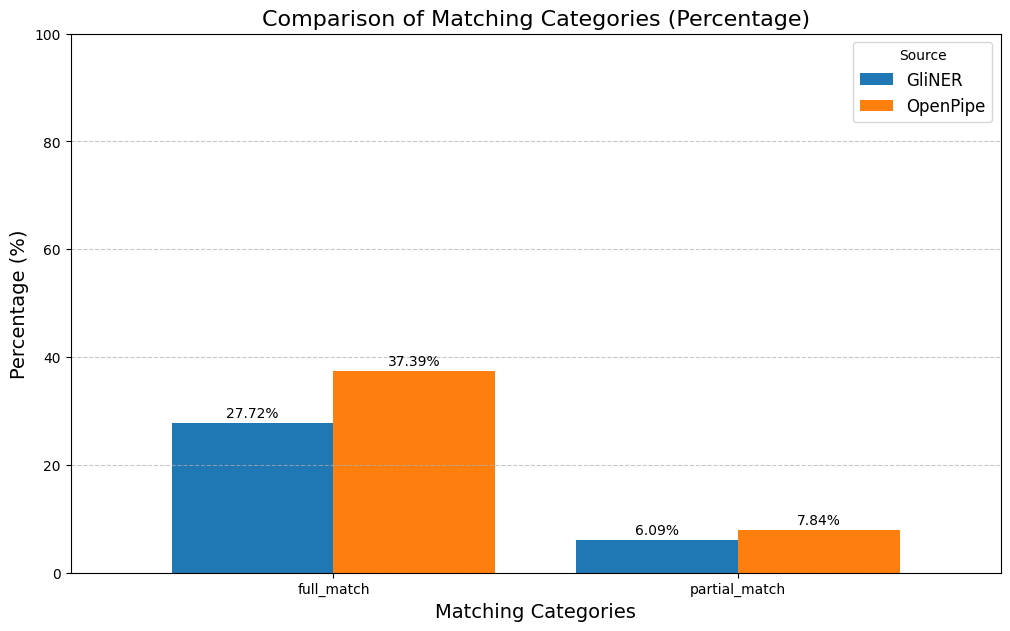

In [ ]:
# drop_not_matched=False for visualizing not_matched counts
plot_chunk_level_match(ground_truth_df, drop_not_matched=True)

## Token Level Evaluation

We will tokenize the texts using the Spark NLP tokenizer and then add labels from each predictions.

In [ ]:
sdf_result = model.transform(spark_df)

token_pred_df = sdf_result.select("doc_id", "text", F.explode(F.arrays_zip(sdf_result.token.begin,
                                                                           sdf_result.token.end,
                                                                           sdf_result.token.result,
                                                                          )).alias("cols"))\
                          .select("doc_id", "text", F.expr("cols['0']").alias("token_begin"),
                                                    F.expr("cols['1']").alias("token_end"),
                                                    F.expr("cols['2']").alias("token")).toPandas()

# aling end indexes with prediction indexes
token_pred_df.token_end = token_pred_df.token_end + 1
token_pred_df

,doc_id,text,token_begin,token_end,token
0,15,\n245096078\nFIH\n9174858\n12/February\n997359\n11/3/1992 12:00:00 AM\nDischarge Summary\nUnsigned\nDIS\nReport Status :\nUnsigned\nADMISSION DATE :\n11/3/92\nDISCHARGE DATE :\n12/6/92\nHISTORY OF...,1,10,245096078
1,15,\n245096078\nFIH\n9174858\n12/February\n997359\n11/3/1992 12:00:00 AM\nDischarge Summary\nUnsigned\nDIS\nReport Status :\nUnsigned\nADMISSION DATE :\n11/3/92\nDISCHARGE DATE :\n12/6/92\nHISTORY OF...,11,14,FIH
2,15,\n245096078\nFIH\n9174858\n12/February\n997359\n11/3/1992 12:00:00 AM\nDischarge Summary\nUnsigned\nDIS\nReport Status :\nUnsigned\nADMISSION DATE :\n11/3/92\nDISCHARGE DATE :\n12/6/92\nHISTORY OF...,15,22,9174858
3,15,\n245096078\nFIH\n9174858\n12/February\n997359\n11/3/1992 12:00:00 AM\nDischarge Summary\nUnsigned\nDIS\nReport Status :\nUnsigned\nADMISSION DATE :\n11/3/92\nDISCHARGE DATE :\n12/6/92\nHISTORY OF...,23,34,12/February
4,15,\n245096078\nFIH\n9174858\n12/February\n997359\n11/3/1992 12:00:00 AM\nDischarge Summary\nUnsigned\nDIS\nReport Status :\nUnsigned\nADMISSION DATE :\n11/3/92\nDISCHARGE DATE :\n12/6/92\nHISTORY OF...,35,41,997359
...,...,...,...,...,...
45167,35,"Patient Summary :\n\nORLANDO VETERANS AFFAIRS MEDICAL CENTER\n\n420 W Magnetic\n\nCANAGA , NEW MEXICO 18288-5119\n\nBring This After Hospital Care Plan To ALL Appointments\n\nAfter Hospital Care P...",10112,10113,(
45168,35,"Patient Summary :\n\nORLANDO VETERANS AFFAIRS MEDICAL CENTER\n\n420 W Magnetic\n\nCANAGA , NEW MEXICO 18288-5119\n\nBring This After Hospital Care Plan To ALL Appointments\n\nAfter Hospital Care P...",10114,10116,on
45169,35,"Patient Summary :\n\nORLANDO VETERANS AFFAIRS MEDICAL CENTER\n\n420 W Magnetic\n\nCANAGA , NEW MEXICO 18288-5119\n\nBring This After Hospital Care Plan To ALL Appointments\n\nAfter Hospital Care P...",10117,10127,24/07/2024
45170,35,"Patient Summary :\n\nORLANDO VETERANS AFFAIRS MEDICAL CENTER\n\n420 W Magnetic\n\nCANAGA , NEW MEXICO 18288-5119\n\nBring This After Hospital Care Plan To ALL Appointments\n\nAfter Hospital Care P...",10128,10133,18:30


#### Add Token Labels & Label Mapping

This code assigns chunk labels from four different sources (`ground_truth_df`, `openpipe_df` to tokens in `token_pred_df`. It determines which chunk label a token belongs to based on its begin position falling within the begin and end range of a chunk.

After the function executes:

The lists `gt_token_labels` and `openpipe_token_labels` contain the corresponding chunk labels for each token in `token_pred_df`.




In [ ]:
import pandas as pd
ground_truth_df = pd.read_csv("/content/gt_text_openpipe_gliner_df.csv")
openpipe_df = pd.read_csv("openpipe_prediction_df.csv")
gliner_pred_df = pd.read_csv("gliner_prediction.csv")
token_pred_df = pd.read_csv("token_df.csv")
token_pred_df.head()

,doc_id,text,token_begin,token_end,token,token_label
0,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,1,10,957770228,IDNUM
1,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,11,14,FIH,LOCATION
2,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,15,22,0408267,IDNUM
3,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,23,33,46769/5v7d,IDNUM
4,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,34,40,237890,IDNUM


In [ ]:
#token_pred_df.to_csv("token_df.csv", index=False)

In [ ]:
gt_token_labels, openpipe_token_labels, gliner_token_labels = assign_token_labels(token_pred_df, ground_truth_df, openpipe_df, gliner_pred_df)

token_pred_df["token_label"] = gt_token_labels
token_pred_df["openpipe_token_label"] = openpipe_token_labels
token_pred_df["gliner_token_label"] = gliner_token_labels

token_pred_df

100%|██████████| 48/48 [03:00<00:00,  3.75s/it]


,doc_id,text,token_begin,token_end,token,token_label,openpipe_token_label,gliner_token_label
0,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,1,10,957770228,IDNUM,O,O
1,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,11,14,FIH,LOCATION,O,O
2,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,15,22,0408267,IDNUM,IDNUM,O
3,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,23,33,46769/5v7d,IDNUM,IDNUM,O
4,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,34,40,237890,IDNUM,IDNUM,O
...,...,...,...,...,...,...,...,...
45167,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",608,620,644.508.1141,CONTACT,O,O
45168,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",621,622,1,O,O,O
45169,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",623,625,of,O,O,O
45170,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",626,628,87,O,O,O


Let's get classification report for the results.

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(token_pred_df["token_label"], token_pred_df["openpipe_token_label"]))

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         AGE       0.00      0.00      0.00       107
     CONTACT       0.80      0.11      0.20        72
        DATE       0.76      0.45      0.56       818
       IDNUM       0.38      0.34      0.36       191
    LOCATION       0.60      0.06      0.11       594
        NAME       0.90      0.64      0.74       770
           O       0.97      0.99      0.98     42620

    accuracy                           0.96     45172
   macro avg       0.63      0.37      0.42     45172
weighted avg       0.95      0.96      0.95     45172



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(token_pred_df["token_label"], token_pred_df["gliner_token_label"]))

              precision    recall  f1-score   support

         AGE       0.80      0.57      0.67       107
     CONTACT       0.08      0.07      0.07        72
        DATE       0.90      0.74      0.81       818
       IDNUM       0.28      0.04      0.06       191
    LOCATION       0.33      0.15      0.20       594
        NAME       0.53      0.04      0.07       770
           O       0.96      0.99      0.98     42620

    accuracy                           0.95     45172
   macro avg       0.55      0.37      0.41     45172
weighted avg       0.94      0.95      0.94     45172



### PHI Or Non-PHI

The de-identification task is crucial in ensuring the privacy of sensitive data. In this context, the primary focus is not on the specific labels of PHI entities but on whether they are successfully detected. When we evaluate the results based on whether the entities are classified as PHI or non-PHI, the outcomes are as follows.

In [ ]:
phi_token_df = token_pred_df.copy()
phi_token_df.token_label = ["PHI" if i != "O" else "Non-PHI" for i in phi_token_df.token_label]
phi_token_df.openpipe_token_label = ["PHI" if i != "O" else "Non-PHI" for i in phi_token_df.openpipe_token_label]
phi_token_df.gliner_token_label = ["PHI" if i != "O" else "Non-PHI" for i in phi_token_df.gliner_token_label]

phi_token_df

,doc_id,text,token_begin,token_end,token,token_label,openpipe_token_label,gliner_token_label
0,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,1,10,957770228,PHI,Non-PHI,Non-PHI
1,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,11,14,FIH,PHI,Non-PHI,Non-PHI
2,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,15,22,0408267,PHI,PHI,Non-PHI
3,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,23,33,46769/5v7d,PHI,PHI,Non-PHI
4,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,34,40,237890,PHI,PHI,Non-PHI
...,...,...,...,...,...,...,...,...
45167,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",608,620,644.508.1141,PHI,Non-PHI,Non-PHI
45168,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",621,622,1,Non-PHI,Non-PHI,Non-PHI
45169,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",623,625,of,Non-PHI,Non-PHI,Non-PHI
45170,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",626,628,87,Non-PHI,Non-PHI,Non-PHI


Let's get classification report for the results.

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(phi_token_df["token_label"], phi_token_df["openpipe_token_label"]))

              precision    recall  f1-score   support

     Non-PHI       0.97      0.99      0.98     42620
         PHI       0.80      0.40      0.53      2552

    accuracy                           0.96     45172
   macro avg       0.88      0.70      0.76     45172
weighted avg       0.96      0.96      0.95     45172



In [ ]:
from sklearn.metrics import classification_report

print(classification_report(phi_token_df["token_label"], phi_token_df["gliner_token_label"]))

              precision    recall  f1-score   support

     Non-PHI       0.96      0.99      0.98     42620
         PHI       0.70      0.32      0.44      2552

    accuracy                           0.95     45172
   macro avg       0.83      0.66      0.71     45172
weighted avg       0.95      0.95      0.95     45172

